In [1]:
import pandas as pd
import numpy as np
import datetime
from functools import reduce
from datetime import timedelta
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

# Fairlearn
from sklearn.metrics import accuracy_score, precision_score
from fairlearn.metrics import MetricFrame, selection_rate, equalized_odds_difference, true_positive_rate, false_positive_rate
from fairlearn.metrics import *

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r'''
\usepackage{mathtools}

\usepackage{helvet}
\renewcommand{\familydefault}{\sfdefault}
% more packages here
'''
plt.rcParams['legend.title_fontsize'] = 14
plt.rcParams["font.family"] = 'sans-serif'

# Load data

In [2]:
rfrls_clients_df = pd.read_csv('../../data/raw/2021_8_26/LIM_REFERRAL_CLIENTS_08262021.csv')
addendum_df = pd.read_csv('../../data/raw/2021_8_26/LIM_ADDENDUM_08262021.csv')
maxscores_df = pd.read_csv('../../data/raw/2021_8_26/LIM_MAXSCORES_08262021.csv')
allscores_df = pd.read_csv('../../data/raw/2021_8_26/LIM_ALLSCORES_08262021.csv')

In [3]:
# restrict dates
df = rfrls_clients_df[(pd.to_datetime(rfrls_clients_df.INTAKE_DT) >= datetime.datetime(2015,1,1))
            &(pd.to_datetime(rfrls_clients_df.INTAKE_DT) <= datetime.datetime(2018,7,31))]

# exclude non-GPS referrals
df = df[~rfrls_clients_df.REF_TYPE.isna()]
df = df[df.REF_TYPE == 'GPS']

# exclude active referrals (exclude ACTIVE_FAMILY_IND == 1)
active_rfrl_ids = addendum_df[addendum_df.ACTIVE_FAMILY_IND == 1]['REFER_ID']
df = df[~df.REFER_ID.isin(active_rfrl_ids)]

# exclude truancy referrals (exclude TRUANCY_ONLY_COURTS_REF == 1)
truancy_rfrl_ids = addendum_df[addendum_df.TRUANCY_ONLY_COURTS_REF == 1]['REFER_ID']
df = df[~df.REFER_ID.isin(truancy_rfrl_ids)]

# include only children
df = df[df.ALL_CHILD == 1]

# add CALL_SCRN_CODE (Screen-in if CALL_SCRN_CODE==1 else screen-out)
df = df.join(addendum_df[['REFER_ID','CALL_SCRN_CODE']].set_index('REFER_ID'), on='REFER_ID')

# exclude referrals intake didn't screen (CALL_SCRN_CODE == -9)
df = df[df.CALL_SCRN_CODE != -9]

# exclude referral-children without an MCI ID
df = df[~df.MCI_ID.isna()]

In [4]:
# add numbers of future removals and rereferrals within 2 yrs and 2 months, respectively
rmvl_df = pd.read_csv('../../data/raw/2021_8_26/LIM_PLACEMENTS_08262021.csv')

df.INTAKE_DT = pd.to_datetime(df.INTAKE_DT)
rmvl_df.RMVL_ENTRY_DT = pd.to_datetime(rmvl_df.RMVL_ENTRY_DT)

print("running...")
df['num_rmvl_730'] = df.apply(lambda x :
                                    np.count_nonzero((rmvl_df.MCI_ID == x.MCI_ID)
                                        &(x.INTAKE_DT <= rmvl_df.RMVL_ENTRY_DT)
                                        &(x.INTAKE_DT > rmvl_df.RMVL_ENTRY_DT-datetime.timedelta(730))), axis=1)

df['num_rerfrl_62'] = df.apply(lambda x :
                                    np.count_nonzero((df.MCI_ID == x.MCI_ID)
                                        &(df.INTAKE_DT > x.INTAKE_DT)
                                        &(df.INTAKE_DT < x.INTAKE_DT + datetime.timedelta(62))), axis=1)

df['HighRiskOutcome'] = ((df['num_rmvl_730'] > 0) | (df['num_rerfrl_62'] > 0)).astype(int)


print("done.")

running...
done.


In [5]:
# exclude referrals with RACE == NaN
df = df[~df.RACE.isna()]

# make new RACE_CYF var (same as RACE from original data)
df.RACE_CYF = df.RACE.copy()

# recode RACE var: 
# RACE = 'white' if RACE_CYF == 'White' 
# RACE = 'Black' if RACE_CYF contains 'Black or African American'
# RACE = 'other' if RACE (new var) is neither 'white' nor 'Black'
df.loc[df.RACE_CYF == 'White', 'RACE'] = 'white'
df.loc[df.RACE_CYF.str.contains('Black or African American'), 'RACE'] = 'Black'
df.loc[~df.RACE.isin(['white','Black']), 'RACE'] = 'other'

In [6]:
# split data by dates

# pre_df from 1/1/15 to 7/31/16
pre_df = df[(pd.to_datetime(df.INTAKE_DT) >= datetime.datetime(2015,1,1))
            &(pd.to_datetime(df.INTAKE_DT) <= datetime.datetime(2016,7,31))]

# post_df from 12/1/16 to 5/31/18
post_df = df[(pd.to_datetime(df.INTAKE_DT) >= datetime.datetime(2016,8,1))
            &(pd.to_datetime(df.INTAKE_DT) <= datetime.datetime(2018,5,13))]

In [7]:
len(set(pre_df.MCI_ID.to_list()+post_df.MCI_ID.to_list()))

38683

# Section 5.1

In [8]:
# pre-AFST
print("pre all # entries",len(pre_df))
print("pre all # children",len(pre_df.MCI_ID.unique()))
print("pre all # referrals",len(pre_df.REFER_ID.unique()))
print("pre all # entries screen-in",len(pre_df[pre_df.CALL_SCRN_CODE == 1]))
print("pre all # entries screen-out",len(pre_df[pre_df.CALL_SCRN_CODE == 0]))
print("pre all screen-in %",len(pre_df[pre_df.CALL_SCRN_CODE == 1])/len(pre_df))

print()
print("pre Black # entries",len(pre_df[pre_df.RACE=='Black']))
print("pre Black % of rfrls",len(pre_df[pre_df.RACE=='Black'])/len(pre_df))
print("pre Black # screen-in",len(pre_df[(pre_df.RACE=='Black')&(pre_df.CALL_SCRN_CODE == 1)]))
print("pre Black # screen-out",len(pre_df[(pre_df.RACE=='Black')&(pre_df.CALL_SCRN_CODE == 0)]))
print("pre Black screen-in %",len(pre_df[(pre_df.RACE=='Black')&(pre_df.CALL_SCRN_CODE == 1)])/len(pre_df[pre_df.RACE=='Black']))

print()
print("pre white # entries",len(pre_df[pre_df.RACE=='white']))
print("pre white % of rfrls",len(pre_df[pre_df.RACE=='white'])/len(pre_df))
print("pre white # screen-in",len(pre_df[(pre_df.RACE=='white')&(pre_df.CALL_SCRN_CODE == 1)]))
print("pre white # screen-out",len(pre_df[(pre_df.RACE=='white')&(pre_df.CALL_SCRN_CODE == 0)]))
print("pre white screen-in %",len(pre_df[(pre_df.RACE=='white')&(pre_df.CALL_SCRN_CODE == 1)])/len(pre_df[pre_df.RACE=='white']))

# post-AFST
print()
print("post all # entries",len(post_df))
print("post all # children",len(post_df.MCI_ID.unique()))
print("post all # referrals",len(post_df.REFER_ID.unique()))
print("post all # screen-in",len(post_df[post_df.CALL_SCRN_CODE == 1]))
print("post all # screen-out",len(post_df[post_df.CALL_SCRN_CODE == 0]))
print("post all screen-in %",len(post_df[post_df.CALL_SCRN_CODE == 1])/len(post_df))

print()
print("post Black # entries",len(post_df[post_df.RACE=='Black']))
print("post Black % of rfrls",len(post_df[post_df.RACE=='Black'])/len(post_df))
print("post Black # screen-in",len(post_df[(post_df.RACE=='Black')&(post_df.CALL_SCRN_CODE == 1)]))
print("post Black # screen-out",len(post_df[(post_df.RACE=='Black')&(post_df.CALL_SCRN_CODE == 0)]))
print("post Black screen-in %",len(post_df[(post_df.RACE=='Black')&(post_df.CALL_SCRN_CODE == 1)])/len(post_df[post_df.RACE=='Black']))

print()
print("post white # entries",len(post_df[post_df.RACE=='white']))
print("post white % of rfrls",len(post_df[post_df.RACE=='white'])/len(post_df))
print("post white # screen-in",len(post_df[(post_df.RACE=='white')&(post_df.CALL_SCRN_CODE == 1)]))
print("post white # screen-out",len(post_df[(post_df.RACE=='white')&(post_df.CALL_SCRN_CODE == 0)]))
print("post white screen-in %",len(post_df[(post_df.RACE=='white')&(post_df.CALL_SCRN_CODE == 1)])/len(post_df[post_df.RACE=='white']))


pre all # entries 27938
pre all # children 20436
pre all # referrals 13278
pre all # entries screen-in 12902
pre all # entries screen-out 15036
pre all screen-in % 0.4618082897845229

pre Black # entries 12669
pre Black % of rfrls 0.45346839430166797
pre Black # screen-in 6394
pre Black # screen-out 6275
pre Black screen-in % 0.5046965032757124

pre white # entries 12617
pre white % of rfrls 0.4516071300737347
pre white # screen-in 5360
pre white # screen-out 7257
pre white screen-in % 0.42482365063010225

post all # entries 36062
post all # children 25145
post all # referrals 17193
post all # screen-in 16415
post all # screen-out 19647
post all screen-in % 0.45518828683933227

post Black # entries 17531
post Black % of rfrls 0.4861349897398924
post Black # screen-in 8769
post Black # screen-out 8762
post Black screen-in % 0.5001996463407677

post white # entries 15728
post white % of rfrls 0.43613776274194443
post white # screen-in 6776
post white # screen-out 8952
post white screen-i

# Add scores
PAN_Retro data contains AFST scores run retroactively, so they do not contain the glitch that caused erroneous AFST scores to be shown to call screen workers throughout Version 1 of the AFST. About 97% of all Black and white children in the LIM_REFERRAL_CLIENTS data were matched with a score in the PAN_Retro data (as shown below).

In [9]:
rfrl_1416 = pd.read_csv('../../data/stanford_data/PAN_Retro_Run_Referrals_for_2014-2016_provided_2018-08-29.csv', skiprows=1)
rfrl_1618 = pd.read_csv('../../data/stanford_data/PAN_Retro_Run_08012016_07132018.csv')

# Convert raw AFST scores to 1-20, add max scores, and add risk levels
RR_score_df = pd.read_csv('../../data/stanford_data/RR_scorecutoffs.csv')
PL_score_df = pd.read_csv('../../data/stanford_data/PL_scorecutoffs.csv')

RR_bin = RR_score_df['MIN_RISK'].to_list()+[999999.0]
RR_score = RR_score_df['SCORE'].to_list()
PL_bin = PL_score_df['MIN_RISK'].to_list()+[999999.0]
PL_score = PL_score_df['SCORE'].to_list()

rfrl_1416['RR_converted'] = pd.cut(rfrl_1416['RR_SCORE'], bins=RR_bin, labels=RR_score)
rfrl_1416['PL_converted'] = pd.cut(rfrl_1416['PL_SCORE'], bins=PL_bin, labels=PL_score)
rfrl_1618['RR_converted'] = pd.cut(rfrl_1618['RR_SCORE'], bins=RR_bin, labels=RR_score)
rfrl_1618['PL_converted'] = pd.cut(rfrl_1618['PL_SCORE'], bins=PL_bin, labels=PL_score)

# convert to float so they match MAX_score
rfrl_1416['RR_converted'] = rfrl_1416['RR_converted'].astype(float)
rfrl_1416['PL_converted'] = rfrl_1416['PL_converted'].astype(float)
rfrl_1618['RR_converted'] = rfrl_1618['RR_converted'].astype(float)
rfrl_1618['PL_converted'] = rfrl_1618['PL_converted'].astype(float)

# add MAX_score (max of either RR_converted or PL_converted)
rfrl_1416['MAX_score'] = rfrl_1416[['PL_converted','RR_converted']].max(axis=1)
rfrl_1618['MAX_score'] = rfrl_1618[['PL_converted','RR_converted']].max(axis=1)

# pick out max PL or RR score out of all children in referral
rfrl_1416_score = rfrl_1416.groupby(['REFER_ID'])['MAX_score'].max().reset_index()
rfrl_1618_score = rfrl_1618.groupby(['REFER_ID'])['MAX_score'].max().reset_index()

# save the old (per-mci_id) Max_score
rfrl_1416['MAX_score_individual'] = rfrl_1416['MAX_score']
rfrl_1618['MAX_score_individual'] = rfrl_1618['MAX_score']

# drop the old (per-mci_id) Max_score
rfrl_1416 = rfrl_1416.drop(['MAX_score'], axis=1)
rfrl_1618 = rfrl_1618.drop(['MAX_score'], axis=1)

# Join with Max score per referral
rfrl_1416 = pd.merge(how="inner", left=rfrl_1416, right=rfrl_1416_score[['REFER_ID', 'MAX_score']], on="REFER_ID")
rfrl_1618 = pd.merge(how="inner", left=rfrl_1618, right=rfrl_1618_score[['REFER_ID', 'MAX_score']], on="REFER_ID")

# convert RR & PL risk scores to risk levels (Low, Med, High)
level_bin = [0,9,14,20]
level_labels = ['Low_risk', 'Medium_risk', 'High_risk']

rfrl_1416['RR_Risk_level'] = pd.cut(rfrl_1416['RR_converted'], bins=level_bin, labels=level_labels)
rfrl_1416['PL_Risk_level'] = pd.cut(rfrl_1416['PL_converted'], bins=level_bin, labels=level_labels)
rfrl_1416['MAX_level'] = pd.cut(rfrl_1416['MAX_score'], bins=level_bin, labels=level_labels)

rfrl_1618['RR_Risk_level'] = pd.cut(rfrl_1618['RR_converted'], bins=level_bin, labels=level_labels)
rfrl_1618['PL_Risk_level'] = pd.cut(rfrl_1618['PL_converted'], bins=level_bin, labels=level_labels)
rfrl_1618['MAX_level'] = pd.cut(rfrl_1618['MAX_score'], bins=level_bin, labels=level_labels)

# add mandatory screening column
rfrl_1416['MANDATORY_NULL'] = (rfrl_1416['PL_converted'] >= 18).astype(int)
rfrl_1618['MANDATORY_NULL'] = (rfrl_1618['PL_converted'] >= 18).astype(int)

In [10]:
pre_df = pre_df.join(rfrl_1416[['REFER_ID','MCI_ID','PL_converted','MAX_score','MANDATORY_NULL']].set_index(['REFER_ID','MCI_ID']), on = ['REFER_ID','MCI_ID'], how='left')
post_df = post_df.join(rfrl_1618[['REFER_ID','MCI_ID','PL_converted','MAX_score','MANDATORY_NULL']].set_index(['REFER_ID','MCI_ID']), on = ['REFER_ID','MCI_ID'], how='left')

In [11]:
# make sure MAX_score is consistent across all REFER_ID in pre_df and post_df
# pick out max PL or RR score out of all children in referral
pre_df_score = pre_df.groupby(['REFER_ID'])['MAX_score'].max().reset_index()
post_df_score = post_df.groupby(['REFER_ID'])['MAX_score'].max().reset_index()

# save the old (per-mci_id) Max_score
pre_df['MAX_score_individual'] = pre_df['MAX_score']
post_df['MAX_score_individual'] = post_df['MAX_score']

# drop the old (per-mci_id) Max_score
pre_df = pre_df.drop(['MAX_score'], axis=1)
post_df = post_df.drop(['MAX_score'], axis=1)

# Join with Max score per referral
pre_df = pd.merge(how="inner", left=pre_df, right=pre_df_score[['REFER_ID', 'MAX_score']], on="REFER_ID")
post_df = pd.merge(how="inner", left=post_df, right=post_df_score[['REFER_ID', 'MAX_score']], on="REFER_ID")

In [12]:
# add MAX_level
def max_level_bins(score):
    if score < 10: return 'Low_risk'
    elif score < 15: return 'Medium_risk'
    else: return 'High_risk'

pre_df['MAX_level'] = pre_df.MAX_score.apply(lambda x : max_level_bins(x))
post_df['MAX_level'] = post_df.MAX_score.apply(lambda x : max_level_bins(x))

In [13]:
# make sure MANDATORY_NULL is consistent across all REFER_ID in pre_df and post_df
# pick out max MANDATORY_NULL of all children in referral
pre_df_score = pre_df.groupby(['REFER_ID'])['MANDATORY_NULL'].max().reset_index()
post_df_score = post_df.groupby(['REFER_ID'])['MANDATORY_NULL'].max().reset_index()

# drop the old (per-mci_id) MANDATORY_NULL
pre_df = pre_df.drop(['MANDATORY_NULL'], axis=1)
post_df = post_df.drop(['MANDATORY_NULL'], axis=1)

# Join with MANDATORY_NULL per referral
pre_df = pd.merge(how="inner", left=pre_df, right=pre_df_score[['REFER_ID', 'MANDATORY_NULL']], on="REFER_ID")
post_df = pd.merge(how="inner", left=post_df, right=post_df_score[['REFER_ID', 'MANDATORY_NULL']], on="REFER_ID")

In [14]:
print('% no scores in PAN_Retro (pre):',np.count_nonzero(pre_df.MAX_score.isna())/len(pre_df))
print('% no scores in PAN_Retro (post):',np.count_nonzero(post_df.MAX_score.isna())/len(post_df))

% no scores in PAN_Retro (pre): 0.021118190278473763
% no scores in PAN_Retro (post): 0.024263767955188288


In [15]:
print('% no scores in PAN_Retro (post white):',
      np.count_nonzero((post_df.MAX_score.isna())&(post_df.RACE=='white'))/len(post_df[post_df.RACE=='white']))

print('% no scores in PAN_Retro (post Black):',
      np.count_nonzero((post_df.MAX_score.isna())&(post_df.RACE=='Black'))/len(post_df[post_df.RACE=='Black']))

print('% no scores in PAN_Retro (pre white):',
      np.count_nonzero((pre_df.MAX_score.isna())&(pre_df.RACE=='white'))/len(pre_df[pre_df.RACE=='white']))

print('% no scores in PAN_Retro (pre Black):',
      np.count_nonzero((pre_df.MAX_score.isna())&(pre_df.RACE=='Black'))/len(pre_df[pre_df.RACE=='Black']))

% no scores in PAN_Retro (post white): 0.008774160732451679
% no scores in PAN_Retro (post Black): 0.009925275226741201
% no scores in PAN_Retro (pre white): 0.02124118253150511
% no scores in PAN_Retro (pre Black): 0.01736522219591128


In [16]:
# pct of referrals with no score in PAN_Retro have MCI_ID in PAN_Retro
len(post_df[(post_df.MAX_score.isna())
          &(post_df.MCI_ID.isin(rfrl_1618.MCI_ID))])/len(post_df[(post_df.MAX_score.isna())])

0.12571428571428572

In [17]:
post_original = post_df.copy()
pre_original = pre_df.copy()

In [18]:
len(post_df[(post_df.MAX_score.isna())])

875

In [19]:
len(post_df)

36062

In [20]:
# exclude referrals with no retroactive score
post_df = post_df[~post_df.MAX_score.isna()]
pre_df = pre_df[~pre_df.MAX_score.isna()]

In [53]:
# save to file
pre_df.to_csv('../../data/processed/disparity_paper/pre_AFST_with_race_outcomes.csv',index=False)
post_df.to_csv('../../data/processed/disparity_paper/post_AFST_with_race_outcomes.csv',index=False)

In [21]:
# pre-AFST
print("AFST-only screening rates, i.e. AFST score >= 15 or not")
print("pre all # entries",len(pre_df))
print("pre all # screen-in",len(pre_df[pre_df.MAX_score >= 15]))
print("pre all # screen-out",len(pre_df[pre_df.MAX_score < 15]))
print("pre all screen-in %",len(pre_df[pre_df.MAX_score >= 15])/len(pre_df))

print()
print("pre Black # entries",len(pre_df[pre_df.RACE=='Black']))
print("pre Black % of rfrls",len(pre_df[pre_df.RACE=='Black'])/len(pre_df))
print("pre Black # screen-in",len(pre_df[(pre_df.RACE=='Black')&(pre_df.MAX_score >= 15)]))
print("pre Black # screen-out",len(pre_df[(pre_df.RACE=='Black')&(pre_df.MAX_score < 15)]))
print("pre Black screen-in %",len(pre_df[(pre_df.RACE=='Black')&(pre_df.MAX_score >= 15)])/len(pre_df[pre_df.RACE=='Black']))

print()
print("pre white # entries",len(pre_df[pre_df.RACE=='white']))
print("pre white % of rfrls",len(pre_df[pre_df.RACE=='white'])/len(pre_df))
print("pre white # screen-in",len(pre_df[(pre_df.RACE=='white')&(pre_df.MAX_score >= 15)]))
print("pre white # screen-out",len(pre_df[(pre_df.RACE=='white')&(pre_df.MAX_score < 15)]))
print("pre white screen-in %",len(pre_df[(pre_df.RACE=='white')&(pre_df.MAX_score >= 15)])/len(pre_df[pre_df.RACE=='white']))

# post-AFST
print()
print("post all # entries",len(post_df))
print("post all # screen-in",len(post_df[post_df.MAX_score >= 15]))
print("post all # screen-out",len(post_df[post_df.MAX_score < 15]))
print("post all screen-in %",len(post_df[post_df.MAX_score >= 15])/len(post_df))

print()
print("post Black # entries",len(post_df[post_df.RACE=='Black']))
print("post Black % of rfrls",len(post_df[post_df.RACE=='Black'])/len(post_df))
print("post Black # screen-in",len(post_df[(post_df.RACE=='Black')&(post_df.MAX_score >= 15)]))
print("post Black # screen-out",len(post_df[(post_df.RACE=='Black')&(post_df.MAX_score < 15)]))
print("post Black screen-in %",len(post_df[(post_df.RACE=='Black')&(post_df.MAX_score >= 15)])/len(post_df[post_df.RACE=='Black']))

print()
print("post white # entries",len(post_df[post_df.RACE=='white']))
print("post white % of rfrls",len(post_df[post_df.RACE=='white'])/len(post_df))
print("post white # screen-in",len(post_df[(post_df.RACE=='white')&(post_df.MAX_score >= 15)]))
print("post white # screen-out",len(post_df[(post_df.RACE=='white')&(post_df.MAX_score < 15)]))
print("post white screen-in %",len(post_df[(post_df.RACE=='white')&(post_df.MAX_score >= 15)])/len(post_df[post_df.RACE=='white']))


AFST-only screening rates, i.e. AFST score >= 15 or not
pre all # entries 27348
pre all # screen-in 13280
pre all # screen-out 14068
pre all screen-in % 0.48559309638730436

pre Black # entries 12449
pre Black % of rfrls 0.45520696211788797
pre Black # screen-in 7207
pre Black # screen-out 5242
pre Black screen-in % 0.5789220017672102

pre white # entries 12349
pre white % of rfrls 0.45155038759689925
pre white # screen-in 5033
pre white # screen-out 7316
pre white screen-in % 0.4075633654546927

post all # entries 35187
post all # screen-in 20645
post all # screen-out 14542
post all screen-in % 0.5867223690567539

post Black # entries 17357
post Black % of rfrls 0.49327876772671725
post Black # screen-in 11802
post Black # screen-out 5555
post Black screen-in % 0.6799562136313879

post white # entries 15590
post white % of rfrls 0.44306135788785633
post white # screen-in 7835
post white # screen-out 7755
post white screen-in % 0.5025657472738935


In [22]:
# pre-AFST
print("AFST-only screening rates for mandatory screen-in")
print("pre all # entries",len(pre_df))
print("pre all # screen-in",len(pre_df[pre_df.MANDATORY_NULL == 1]))
print("pre all # screen-out",len(pre_df[pre_df.MANDATORY_NULL == 0]))
print("pre all screen-in %",len(pre_df[pre_df.MANDATORY_NULL == 1])/len(pre_df))

print()
print("pre Black # entries",len(pre_df[pre_df.RACE=='Black']))
print("pre Black % of rfrls",len(pre_df[pre_df.RACE=='Black'])/len(pre_df))
print("pre Black # screen-in",len(pre_df[(pre_df.RACE=='Black')&(pre_df.MANDATORY_NULL == 1)]))
print("pre Black # screen-out",len(pre_df[(pre_df.RACE=='Black')&(pre_df.MANDATORY_NULL == 0)]))
print("pre Black screen-in %",len(pre_df[(pre_df.RACE=='Black')&(pre_df.MANDATORY_NULL == 1)])/len(pre_df[pre_df.RACE=='Black']))

print()
print("pre white # entries",len(pre_df[pre_df.RACE=='white']))
print("pre white % of rfrls",len(pre_df[pre_df.RACE=='white'])/len(pre_df))
print("pre white # screen-in",len(pre_df[(pre_df.RACE=='white')&(pre_df.MANDATORY_NULL == 1)]))
print("pre white # screen-out",len(pre_df[(pre_df.RACE=='white')&(pre_df.MANDATORY_NULL == 0)]))
print("pre white screen-in %",len(pre_df[(pre_df.RACE=='white')&(pre_df.MANDATORY_NULL == 1)])/len(pre_df[pre_df.RACE=='white']))

# post-AFST
print()
print("post all # entries",len(post_df))
print("post all # screen-in",len(post_df[post_df.MANDATORY_NULL == 1]))
print("post all # screen-out",len(post_df[post_df.MANDATORY_NULL == 0]))
print("post all screen-in %",len(post_df[post_df.MANDATORY_NULL == 1])/len(post_df))

print()
print("post Black # entries",len(post_df[post_df.RACE=='Black']))
print("post Black % of rfrls",len(post_df[post_df.RACE=='Black'])/len(post_df))
print("post Black # screen-in",len(post_df[(post_df.RACE=='Black')&(post_df.MANDATORY_NULL == 1)]))
print("post Black # screen-out",len(post_df[(post_df.RACE=='Black')&(post_df.MANDATORY_NULL == 0)]))
print("post Black screen-in %",len(post_df[(post_df.RACE=='Black')&(post_df.MANDATORY_NULL == 1)])/len(post_df[post_df.RACE=='Black']))

print()
print("post white # entries",len(post_df[post_df.RACE=='white']))
print("post white % of rfrls",len(post_df[post_df.RACE=='white'])/len(post_df))
print("post white # screen-in",len(post_df[(post_df.RACE=='white')&(post_df.MANDATORY_NULL == 1)]))
print("post white # screen-out",len(post_df[(post_df.RACE=='white')&(post_df.MANDATORY_NULL == 0)]))
print("post white screen-in %",len(post_df[(post_df.RACE=='white')&(post_df.MANDATORY_NULL == 1)])/len(post_df[post_df.RACE=='white']))


AFST-only screening rates for mandatory screen-in
pre all # entries 27348
pre all # screen-in 4284
pre all # screen-out 23064
pre all screen-in % 0.15664765247915752

pre Black # entries 12449
pre Black % of rfrls 0.45520696211788797
pre Black # screen-in 2563
pre Black # screen-out 9886
pre Black screen-in % 0.20587999036067153

pre white # entries 12349
pre white % of rfrls 0.45155038759689925
pre white # screen-in 1317
pre white # screen-out 11032
pre white screen-in % 0.10664831160417848

post all # entries 35187
post all # screen-in 9385
post all # screen-out 25802
post all screen-in % 0.26671782192286925

post Black # entries 17357
post Black % of rfrls 0.49327876772671725
post Black # screen-in 5624
post Black # screen-out 11733
post Black screen-in % 0.32401912772944635

post white # entries 15590
post white % of rfrls 0.44306135788785633
post white # screen-in 3252
post white # screen-out 12338
post white screen-in % 0.2085952533675433


# Plots

## Figure 1

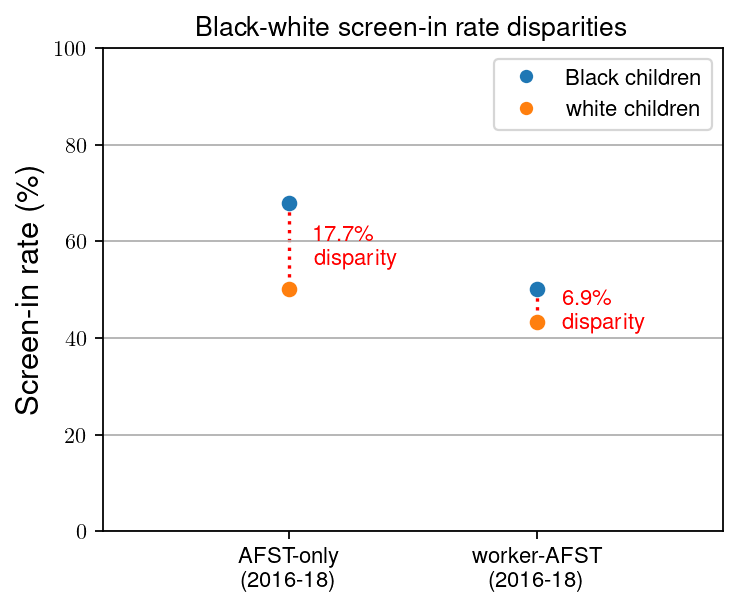

In [23]:
from matplotlib.lines import Line2D

pre_black = pre_df.loc[pre_df.RACE=='Black']
pre_white = pre_df.loc[pre_df.RACE=='white']
post_black = post_df.loc[post_df.RACE=='Black']
post_white = post_df.loc[post_df.RACE=='white']

afstonly_screenrate_black = 100*np.count_nonzero(post_black['MAX_score']>=15)/len(post_black)
afstonly_screenrate_white = 100*np.count_nonzero(post_white['MAX_score']>=15)/len(post_white)
workerafst_screenrate_black = 100*np.count_nonzero(post_black['CALL_SCRN_CODE']==1)/len(post_black)
workerafst_screenrate_white = 100*np.count_nonzero(post_white['CALL_SCRN_CODE']==1)/len(post_white)

afstonly_std_black = np.sqrt((100*(post_black['MAX_score']>=15)).var()/len(post_black))
afstonly_std_white = np.sqrt((100*(post_white['MAX_score']>=15)).var()/len(post_white))
workerafst_std_black = np.sqrt((100*(post_black['CALL_SCRN_CODE']==1)).var()/len(post_black))
workerafst_std_white = np.sqrt((100*(post_white['CALL_SCRN_CODE']==1)).var()/len(post_white))

std_black = [0,afstonly_std_black,workerafst_std_black,0]
std_white = [afstonly_std_white,workerafst_std_white]

data_black = {'':-10, 'AFST-only\n(2016-18)': afstonly_screenrate_black, 'worker-AFST\n(2016-18)': workerafst_screenrate_black, ' ':-10}
data_white = {'AFST-only\n(2016-18)': afstonly_screenrate_white, 'worker-AFST\n(2016-18)': workerafst_screenrate_white}

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Black children', markerfacecolor='tab:blue', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='white children', markerfacecolor='tab:orange', markersize=7)]

line_afstonly = [[1, afstonly_screenrate_black],[1, afstonly_screenrate_white]]
line_workerafst = [[2, workerafst_screenrate_black],[2, workerafst_screenrate_white]]

plt.figure(figsize=(5, 4), dpi=160)
plt.plot([line_afstonly[0][0], line_afstonly[1][0]], [line_afstonly[0][1], line_afstonly[1][1]], color='r', linestyle=':',zorder=1)
plt.plot([line_workerafst[0][0], line_workerafst[1][0]], [line_workerafst[0][1], line_workerafst[1][1]], color='r', linestyle=':',zorder=1)
plt.scatter(data_black.keys(), data_black.values(),zorder=2)
plt.scatter(data_white.keys(), data_white.values(),zorder=2)
#plt.errorbar(data_black.keys(), data_black.values(), yerr=std_black, fmt='o', zorder=2)
#plt.errorbar(data_white.keys(), data_white.values(), yerr=std_white, fmt='o', zorder=2)
plt.text(1.1,(afstonly_screenrate_black+afstonly_screenrate_white)/2-4, str(round(afstonly_screenrate_black-afstonly_screenrate_white,1))+'\% \ndisparity',color='r')
plt.text(2.1,(workerafst_screenrate_black+workerafst_screenrate_white)/2-5, str(round(workerafst_screenrate_black-workerafst_screenrate_white,1))+'\% \ndisparity',color='r',zorder=3)
plt.ylim(0,100)
axes = plt.gca()
axes.yaxis.grid()
plt.xlim(0.25,2.75)
plt.title('Black-white screen-in rate disparities')
plt.ylabel('Screen-in rate (\%)',fontsize=14)
plt.legend(handles=legend_elements)
plt.savefig('../../figures/change_in_screen_in_rate.png', dpi=600, bbox_inches='tight')
plt.show()

## Worker-AFST vs AFST-only Screening Rate Disparities by threshold

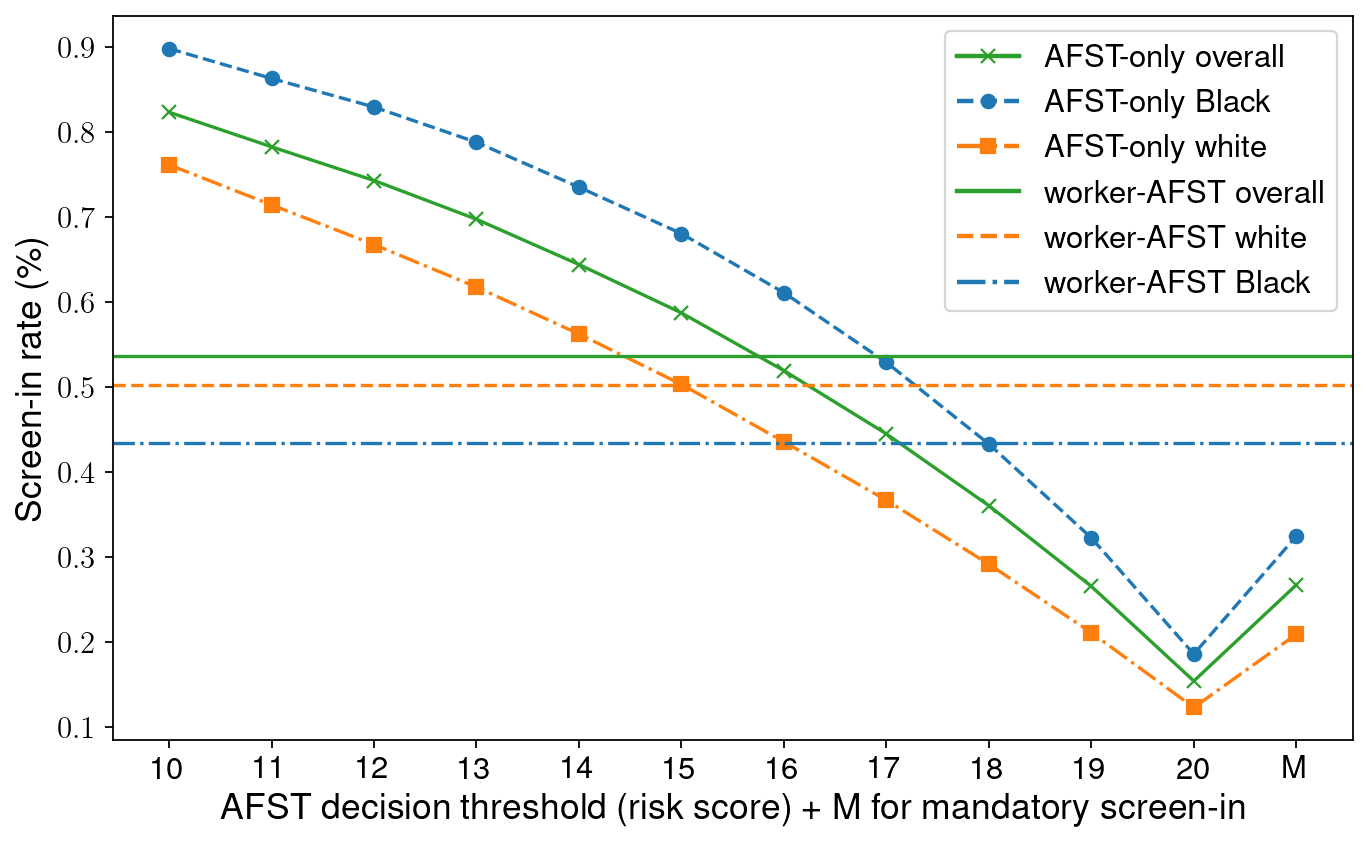

In [24]:
humanAI_black_screen_groupby = post_df.groupby(['RACE','CALL_SCRN_CODE']).size()
humanAI_black_groupby = post_df.groupby(['RACE']).size()
humanAI_screen_groupby = post_df.groupby('CALL_SCRN_CODE').size()

num_black_screenin_humanAI = humanAI_black_screen_groupby['Black',1]
num_black_rfrl_humanAI = humanAI_black_groupby['Black']
num_white_screenin_humanAI = humanAI_black_screen_groupby['white',1]
num_white_rfrl_humanAI = humanAI_black_groupby['white']
num_screenin_humanAI = humanAI_screen_groupby[0]
num_rfrl_humanAI = len(post_df)

humanAI_black_screenin_rate = num_black_screenin_humanAI/num_black_rfrl_humanAI
humanAI_white_screenin_rate = num_white_screenin_humanAI/num_white_rfrl_humanAI
humanAI_disparity = humanAI_black_screenin_rate - humanAI_white_screenin_rate
humanAI_overall_screenin_rate = num_screenin_humanAI/num_rfrl_humanAI

humanAI_pre_black_screen_groupby = pre_df.groupby(['RACE','CALL_SCRN_CODE']).size()
humanAI_pre_black_groupby = pre_df.groupby(['RACE']).size()
humanAI_pre_screen_groupby = pre_df.groupby('CALL_SCRN_CODE').size()

num_black_screenin_humanAI_pre = humanAI_pre_black_screen_groupby['Black',1]
num_black_rfrl_humanAI_pre = humanAI_pre_black_groupby['Black']
num_white_screenin_humanAI_pre = humanAI_pre_black_screen_groupby['white',1]
num_white_rfrl_humanAI_pre = humanAI_pre_black_groupby['white']
num_screenin_humanAI_pre = humanAI_pre_screen_groupby[1]
num_rfrl_humanAI_pre = len(pre_df)

humanAI_pre_black_screenin_rate = num_black_screenin_humanAI_pre/num_black_rfrl_humanAI_pre
humanAI_pre_white_screenin_rate = num_white_screenin_humanAI_pre/num_white_rfrl_humanAI_pre
humanAI_pre_disparity = humanAI_pre_black_screenin_rate - humanAI_pre_white_screenin_rate
humanAI_pre_overall_screenin_rate = num_screenin_humanAI_pre/num_rfrl_humanAI_pre

# define df for cases <= May 13, 2018
post_df = post_df.loc[pd.to_datetime(post_df['INTAKE_DT']) <= pd.to_datetime('2018-05-13')]

AI_overall_screenin_rate = {}
AI_black_screenin_rate = {}
AI_white_screenin_rate = {}
AI_disparity_screenin_rate = {}

for i in range(1,21):
    AI_overall_screenin_rate[i] = np.count_nonzero(post_df['MAX_score'] >= i)/len(post_df)
    AI_black_screenin_rate[i] = np.count_nonzero(post_df.loc[post_df['RACE']=='Black']['MAX_score'] >= i)/len(post_df.loc[post_df['RACE']=='Black'])
    AI_white_screenin_rate[i] = np.count_nonzero(post_df.loc[post_df['RACE']=='white']['MAX_score'] >= i)/len(post_df.loc[post_df['RACE']=='white'])
    AI_disparity_screenin_rate[i] = AI_white_screenin_rate[i]-AI_black_screenin_rate[i]
    
    
AI_overall_screenin_rate['M'] = np.count_nonzero(post_df['MANDATORY_NULL'])/len(post_df)
AI_black_screenin_rate['M'] = np.count_nonzero(post_df.loc[post_df['RACE']=='Black']['MANDATORY_NULL'])/len(post_df.loc[post_df['RACE']=='Black'])
AI_white_screenin_rate['M'] = np.count_nonzero(post_df.loc[post_df['RACE']=='white']['MANDATORY_NULL'])/len(post_df.loc[post_df['RACE']=='white'])
AI_disparity_screenin_rate['M'] = AI_white_screenin_rate['M']-AI_black_screenin_rate['M']


plt.figure(figsize=(10,6), dpi=160)

#x_ticks = range(10, 21)
# plot lines
plt.plot(list(AI_overall_screenin_rate.keys())[9:], list(AI_overall_screenin_rate.values())[9:], color = 'tab:green', label = "AFST-only overall", linestyle="-", marker="x")
plt.plot(list(AI_black_screenin_rate.keys())[9:], list(AI_black_screenin_rate.values())[9:], color = 'tab:blue', label = "AFST-only Black", linestyle="--", marker='o')
plt.plot(list(AI_white_screenin_rate.keys())[9:], list(AI_white_screenin_rate.values())[9:], color = 'tab:orange', label = "AFST-only white", linestyle='-.', marker='s')

plt.axhline(humanAI_overall_screenin_rate, color = 'tab:green', label = "worker-AFST overall", linestyle="-")
plt.axhline(humanAI_black_screenin_rate, color = 'tab:orange', label = "worker-AFST white", linestyle="--")
plt.axhline(humanAI_white_screenin_rate, color = 'tab:blue', label = "worker-AFST Black", linestyle="-.")
# plt.plot(x_ticks, AI_white_screenin_rate[9:], color = 'lightgrey', label = "White Accuracy", linestyle="-", marker='.')

# plt.plot(x_ticks, AI_disparity[9:], label = "Disparity", linestyle="-", marker='.')
plt.xlabel('AFST decision threshold (risk score) + M for mandatory screen-in', fontsize=16)
plt.ylabel('Screen-in rate (\%)', fontsize=16)
#plt.xticks(x_ticks)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

legend = plt.legend(prop={'size': 14})
for handle in legend.legendHandles:
    handle.set_linewidth(2.0)
    
plt.savefig('../../figures/screenin_rate_per_threshold.png', dpi=600, bbox_inches='tight')
plt.show()

## Compare Accuracy

In [25]:
# Question: Can algorithm make different decisions between individuals in a referral?  
# e.g. screen-in some / screen-out some in a referral

#### Plot disparities pre- & post-AFST

In [26]:
def disparity_calc(data, decision_type, threshold, metric):
    # decision_type options: 'workerAFST', 'AFST_threshold', 'AFST_mandatory'
    # set up predictions & outcomes
    if decision_type == 'AFST_threshold':
        y_pred = data['MAX_score'] >= threshold
    elif decision_type == 'workerAFST':
        y_pred = data['CALL_SCRN_CODE']
    elif decision_type == 'AFST_mandatory':
        y_pred = data['MANDATORY_NULL']
        
    y_true = data['HighRiskOutcome']
    sens_attrs = data['RACE']

    # calculate disparity
    mf = MetricFrame(metric=metric, y_true=y_true, y_pred=y_pred, sensitive_features=sens_attrs)
    return abs(mf.by_group['white']-mf.by_group['Black'])

In [27]:
def plot_pre_post_disparity(data_pre = pre_df, data_post = post_df, metric = accuracy_score, ylabel='Accuracy'):
    
    # calculate disparities
    workerAFST_disparity_pre = disparity_calc(data=data_pre, decision_type='workerAFST', threshold=0, metric=metric)
    workerAFST_disparity_post = disparity_calc(data=data_post, decision_type='workerAFST', threshold=0, metric=metric)
    
    AFSTonly_disparity_pre = {}
    AFSTonly_disparity_post = {}
    
    for score in range(1,21):
        AFSTonly_disparity_pre[score] = disparity_calc(data=data_pre, decision_type='AFST_threshold', threshold=score, metric=metric)
        AFSTonly_disparity_post[score] = disparity_calc(data=data_post, decision_type='AFST_threshold', threshold=score, metric=metric)
    
    AFSTonly_disparity_pre['M'] = disparity_calc(data=data_pre, decision_type='AFST_mandatory', threshold=0, metric=metric)
    AFSTonly_disparity_post['M'] = disparity_calc(data=data_post, decision_type='AFST_mandatory', threshold=0, metric=metric)
    
    # plot
    plt.figure(figsize=(10,6), dpi=160)
    plt.plot(list(AFSTonly_disparity_pre.keys())[9:], list(AFSTonly_disparity_pre.values())[9:], color = 'tab:orange', label = "AFST-only (2015-2016)", linestyle="--", marker="x")
    plt.plot(list(AFSTonly_disparity_post.keys())[9:], list(AFSTonly_disparity_post.values())[9:], color = 'tab:blue', label = "AFST-only (2016-2018)", linestyle="-", marker='o')

    plt.axhline(workerAFST_disparity_pre, color = 'tab:green', label = "worker-only (2015-2016)", linestyle="--")
    plt.axhline(workerAFST_disparity_post, color = 'tab:red', label = "worker-AFST (2016-2018)", linestyle="-")

    plt.xlabel('AFST decision threshold (risk score) + M for mandatory screen-in', fontsize=16)
    plt.ylabel(f'{ylabel} disparity (\%)', fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    legend = plt.legend(prop={'size': 12})
    for handle in legend.legendHandles:
        handle.set_linewidth(2.0)
        
    fig_file_dict = {'True Positive Rate':'tpr',
                    'Screen-in rate':'screen_in_rate',
                    'Accuracy':'accuracy',
                    'Screen-in rate':'screen_in_rate',
                    'False Positive Rate':'fpr',
                    'Precision':'precision'}

    plt.savefig(f'../../figures/{fig_file_dict[ylabel]}_disparity.png', dpi=600, bbox_inches='tight')
    plt.show()
    


In [28]:
y_pred = pre_df['MAX_score'] >= 15
y_true = pre_df['HighRiskOutcome']
sens_attrs = pre_df['RACE']

# calculate disparity
mf = MetricFrame(metric=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=sens_attrs)
mf.by_group['white']-mf.by_group['Black']

0.10078471203078654

In [29]:
y_pred = pre_df['CALL_SCRN_CODE']
mf = MetricFrame(metric=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=sens_attrs)
mf.by_group['white']-mf.by_group['Black']

0.04579268401717601

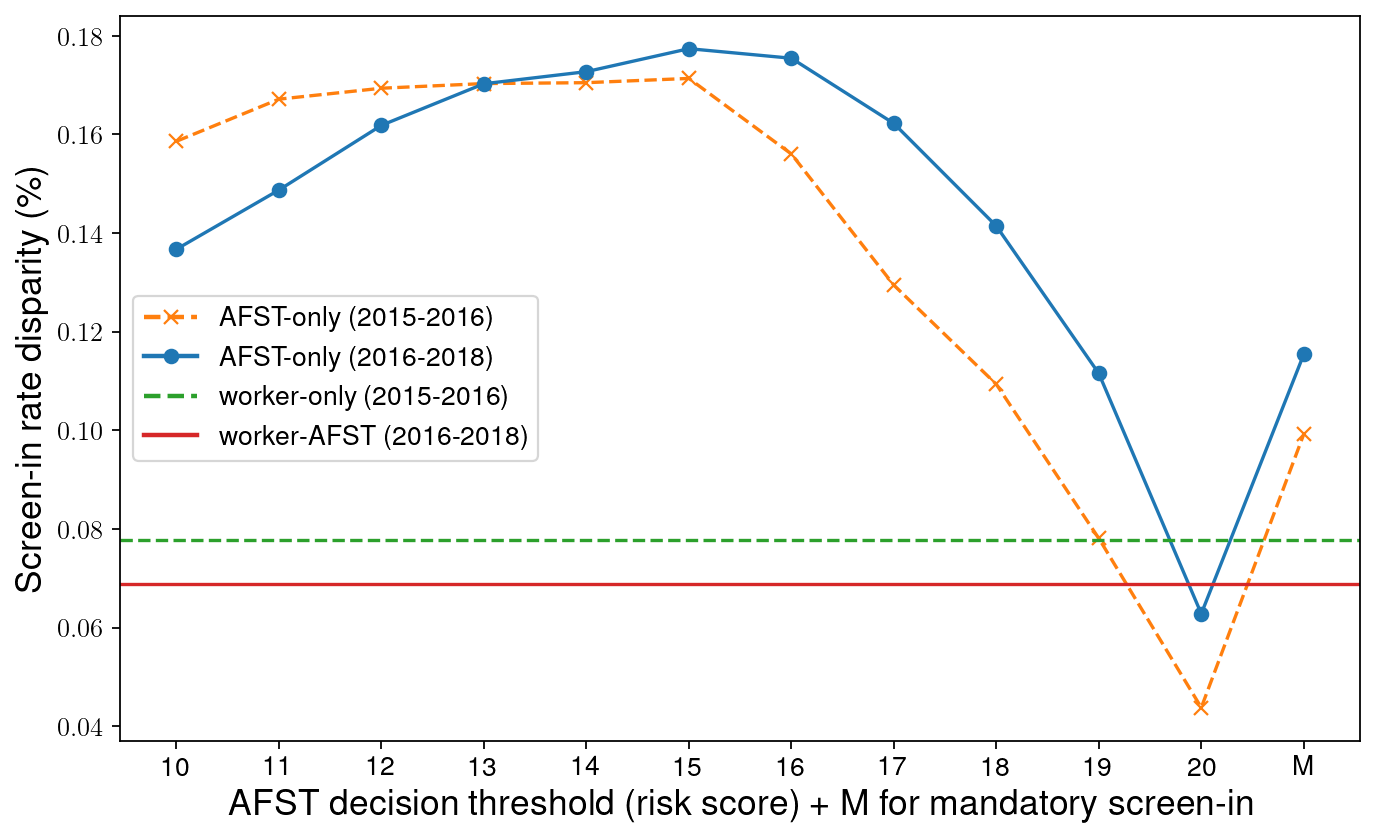

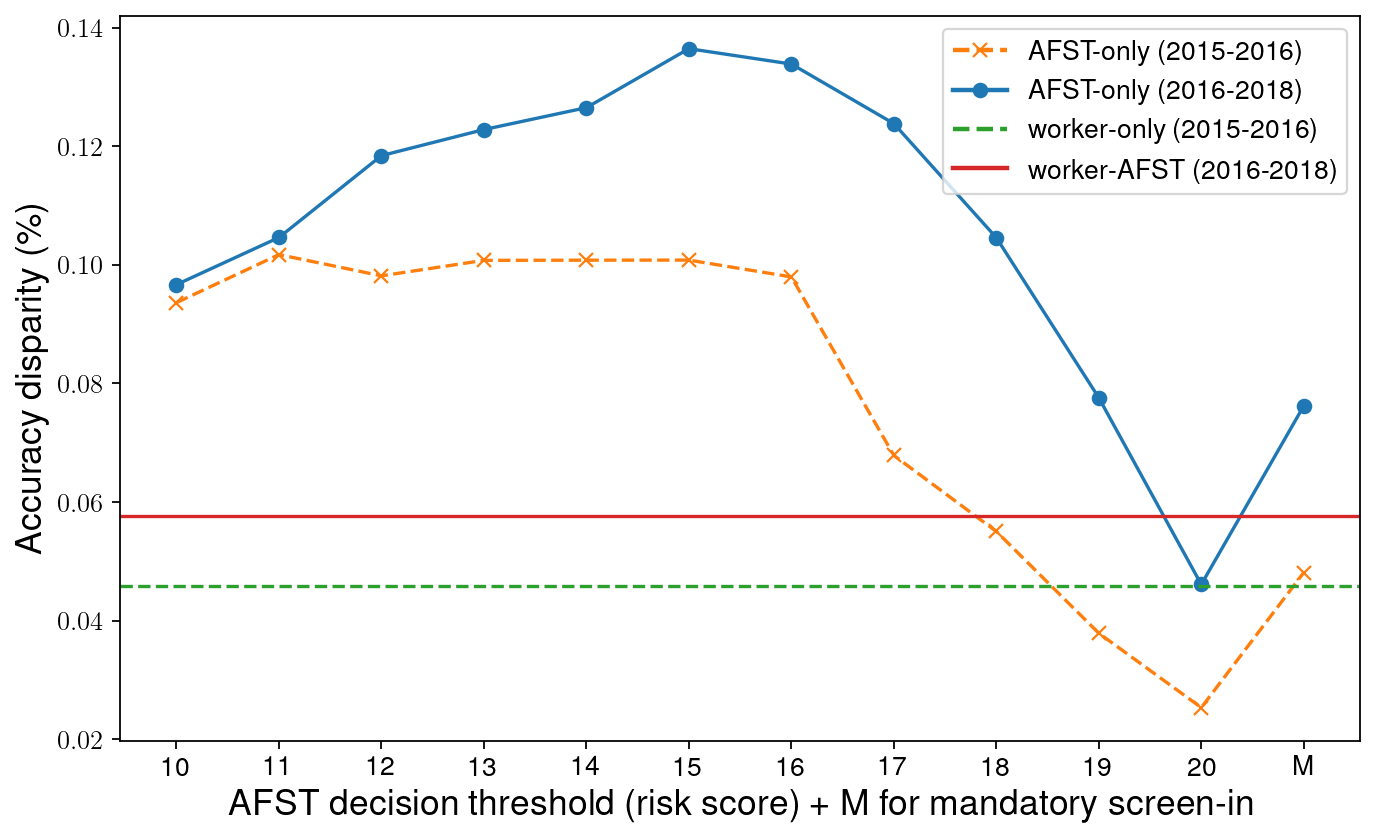

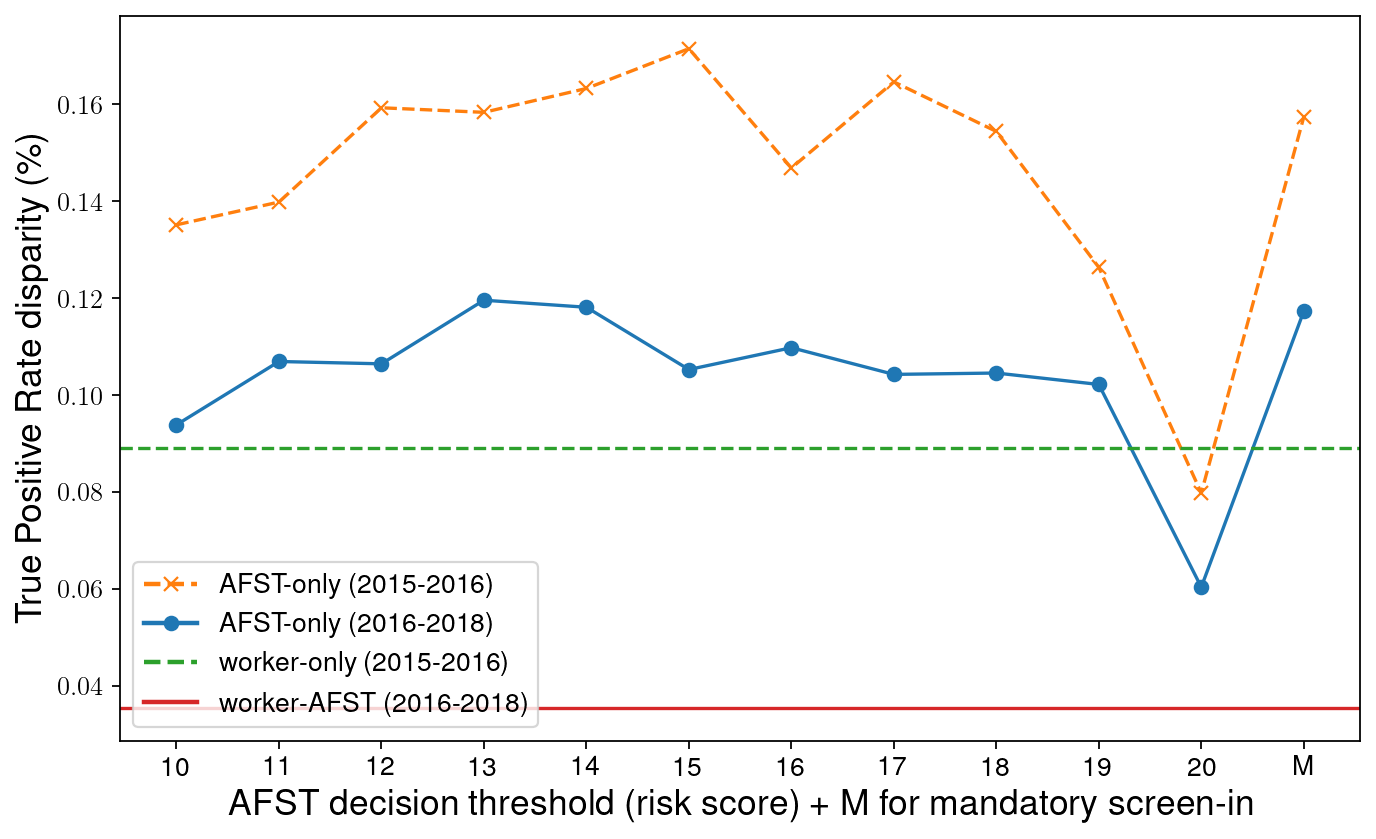

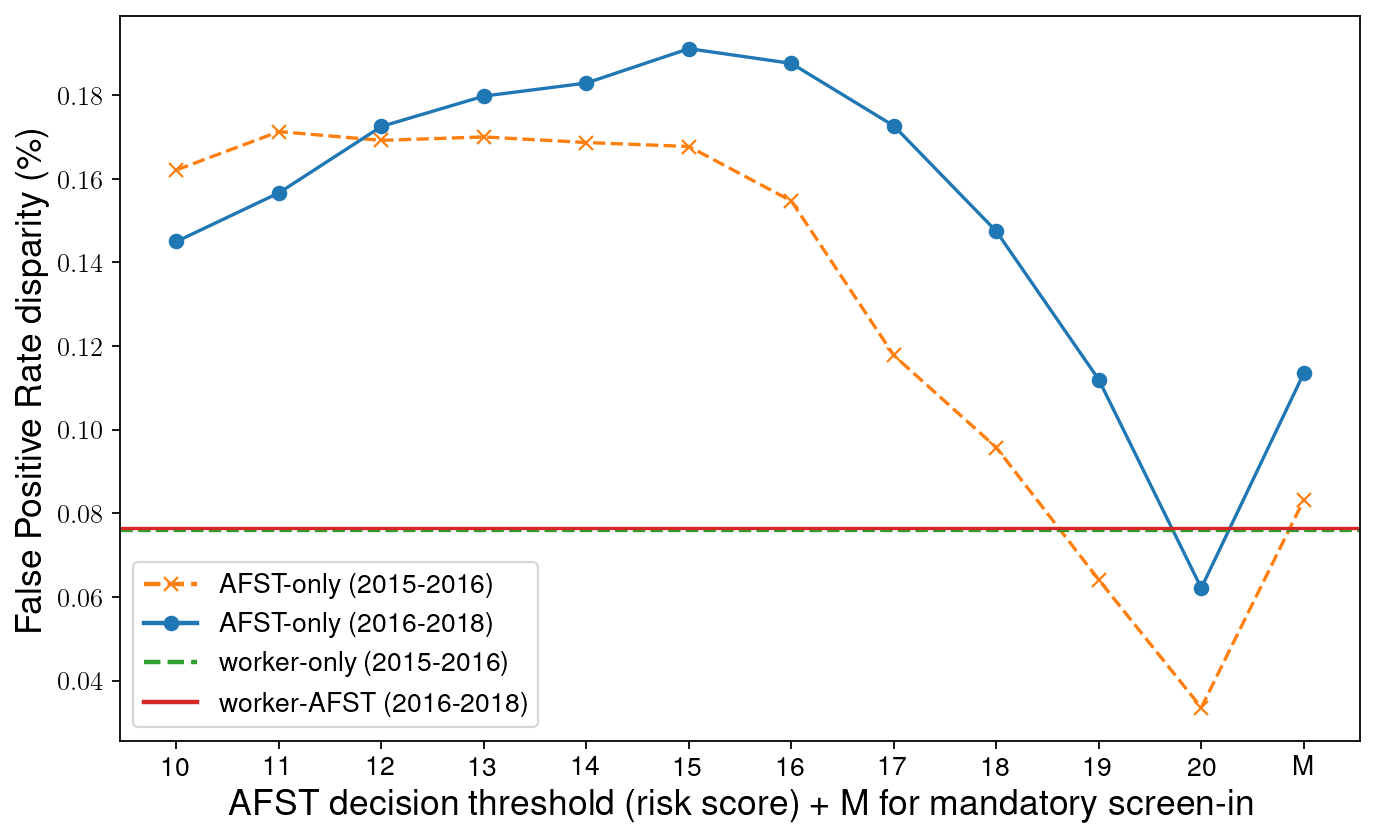

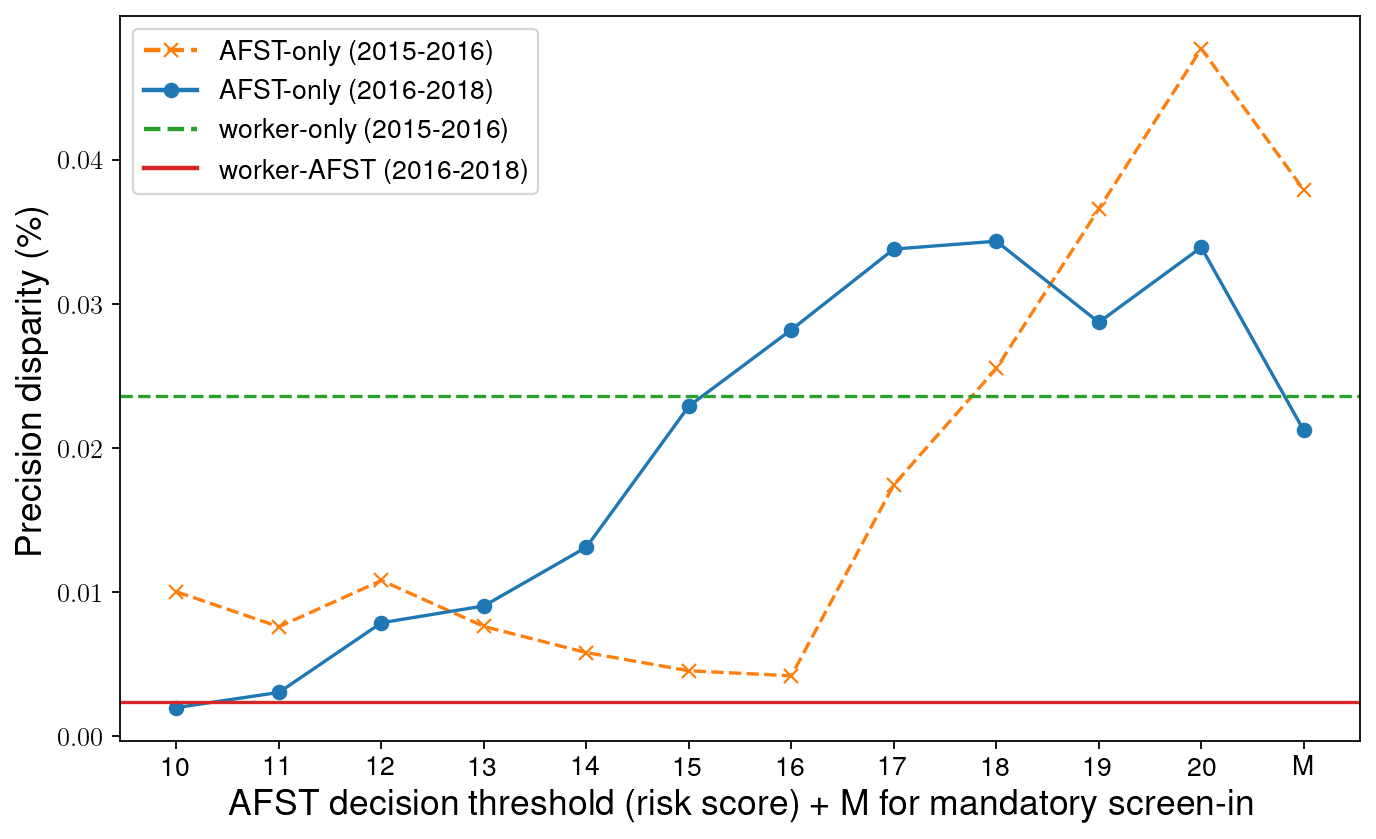

In [30]:
plot_pre_post_disparity(metric=selection_rate, ylabel='Screen-in rate')
plot_pre_post_disparity(metric=accuracy_score, ylabel='Accuracy')
plot_pre_post_disparity(metric=true_positive_rate, ylabel='True Positive Rate')
plot_pre_post_disparity(metric=false_positive_rate, ylabel='False Positive Rate')
plot_pre_post_disparity(metric=precision_score, ylabel='Precision')

In [31]:
## calculate human-AI accuracy
# set up predictions & outcomes
human_AI_decision = post_df['CALL_SCRN_CODE']
y_true = post_df['HighRiskOutcome']
y_pred = human_AI_decision
sens_attrs = post_df['RACE']

# calculate accuracy
acc_worker = MetricFrame(metric=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features = sens_attrs)

# print
print("Human-AI Decisions")
print("Overall Accuracy: ", acc_worker.overall)
print("Group Accuracy: ", acc_worker.by_group[['white','Black']])
humanAI_accuracy = [acc_worker.overall, acc_worker.by_group['white'], acc_worker.by_group['Black']]

Human-AI Decisions
Overall Accuracy:  0.5104726177281382
Group Accuracy:  RACE
white    0.536369
Black    0.478712
Name: accuracy_score, dtype: object


In [32]:
AI_overall_accuracy = {}
AI_black_accuracy = {}
AI_white_accuracy = {}
AI_disparity_accuracy = {}
y_true = post_df['HighRiskOutcome']
sens_attrs = post_df['RACE']

for i in range(1,21):
    y_pred = post_df['MAX_score'] >= i
    acc_ai = MetricFrame(metric = accuracy_score, y_true = y_true, y_pred = y_pred, sensitive_features = sens_attrs)
    
    AI_overall_accuracy[i] = acc_ai.overall
    AI_black_accuracy[i] = acc_ai.by_group['Black']
    AI_white_accuracy[i] = acc_ai.by_group['white']
    AI_disparity_accuracy[i] = acc_ai.by_group['white'] - acc_ai.by_group['Black']
    
## calculate accuracy for mandatory screen-ins
# set up predictions & outcomes
AI_decision = post_df['MANDATORY_NULL']
y_true = post_df['HighRiskOutcome']
y_pred = AI_decision
sens_attrs = post_df['RACE']

# calculate accuracy
acc_mand = MetricFrame(metric=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features = sens_attrs)

AI_overall_accuracy['M'] = acc_mand.overall
AI_black_accuracy['M'] = acc_mand.by_group['Black']
AI_white_accuracy['M'] = acc_mand.by_group['white']
AI_disparity_accuracy['M'] = acc_mand.by_group['white'] - acc_ai.by_group['Black']

AI_accuracy_mand = [acc_mand.overall, acc_mand.by_group['white'], acc_mand.by_group['Black']]

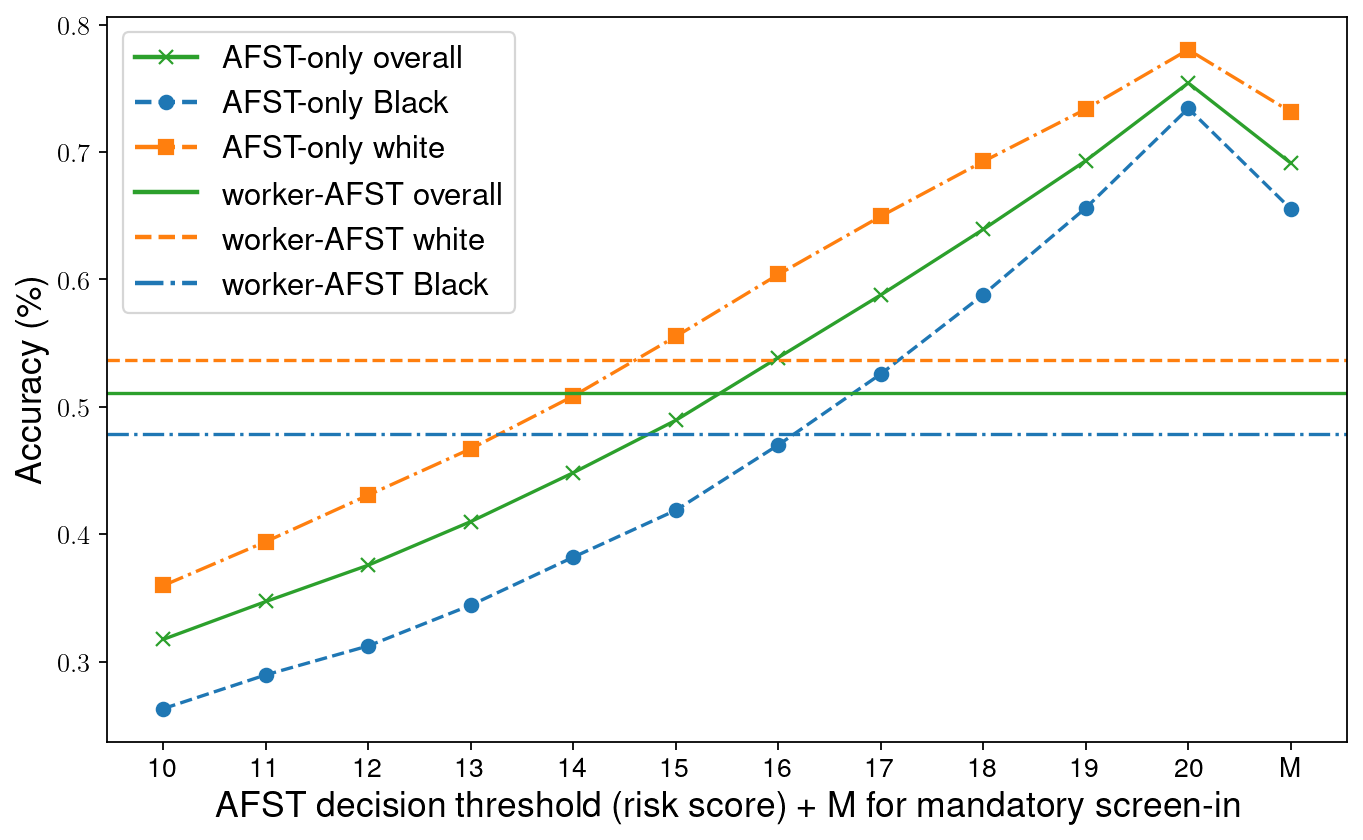

In [33]:
plt.figure(figsize=(10,6), dpi=160)

#x_ticks = range(10, 21)
# plot lines
plt.plot(list(AI_overall_accuracy.keys())[9:], list(AI_overall_accuracy.values())[9:], color = 'tab:green', label = "AFST-only overall", linestyle="-", marker="x")
plt.plot(list(AI_black_accuracy.keys())[9:], list(AI_black_accuracy.values())[9:], color = 'tab:blue', label = "AFST-only Black", linestyle="--", marker='o')
plt.plot(list(AI_white_accuracy.keys())[9:], list(AI_white_accuracy.values())[9:], color = 'tab:orange', label = "AFST-only white", linestyle='-.', marker='s')

plt.axhline(humanAI_accuracy[0], color = 'tab:green', label = "worker-AFST overall", linestyle="-")
plt.axhline(humanAI_accuracy[1], color = 'tab:orange', label = "worker-AFST white", linestyle="--")
plt.axhline(humanAI_accuracy[2], color = 'tab:blue', label = "worker-AFST Black", linestyle="-.")
# plt.plot(x_ticks, AI_white_accuracy[9:], color = 'lightgrey', label = "White Accuracy", linestyle="-", marker='.')

# plt.plot(x_ticks, AI_disparity[9:], label = "Disparity", linestyle="-", marker='.')
plt.xlabel('AFST decision threshold (risk score) + M for mandatory screen-in', fontsize=16)
plt.ylabel('Accuracy (\%)', fontsize=16)
#plt.xticks(x_ticks)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

legend = plt.legend(prop={'size': 14})
for handle in legend.legendHandles:
    handle.set_linewidth(2.0)
    
plt.savefig(f'../../figures/accuracy_per_threshold.png', dpi=600, bbox_inches='tight')
plt.show()

In [34]:
print(round(AI_white_accuracy[15]*100,1))
print(round(AI_overall_accuracy[15]*100,1))
print(round(AI_black_accuracy[15]*100,1))
print(round((AI_white_accuracy[15]-AI_black_accuracy[14])*100,1))

print(round(humanAI_accuracy[1]*100,1))
print(round(humanAI_accuracy[0]*100,1))
print(round(humanAI_accuracy[2]*100,1))
print(round((humanAI_accuracy[1]-humanAI_accuracy[2])*100,1))

55.5
48.9
41.9
17.3
53.6
51.0
47.9
5.8


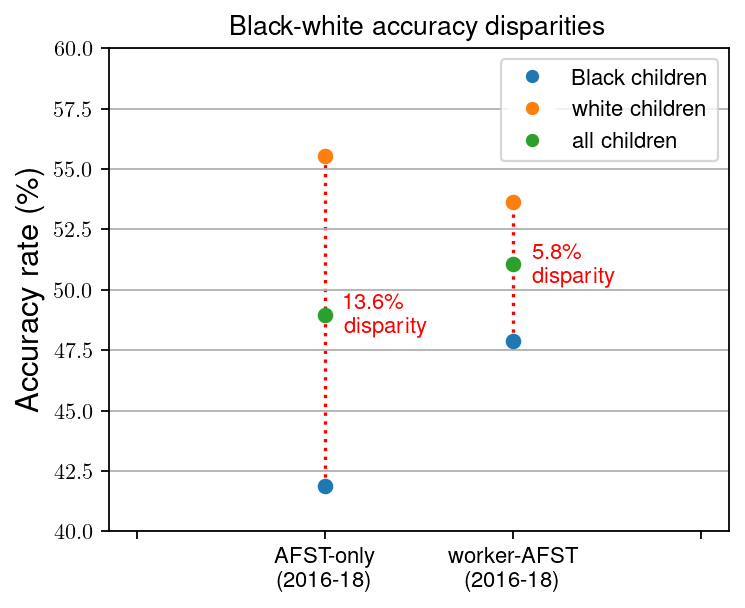

41.9
55.5
48.9
47.9
53.6
51.0


In [35]:
data_black = {'':-10, 'AFST-only\n(2016-18)': 100*AI_black_accuracy[15], 'worker-AFST\n(2016-18)': round(humanAI_accuracy[2]*100,2), ' ':-10}
data_white = {'AFST-only\n(2016-18)': 100*AI_white_accuracy[15], 'worker-AFST\n(2016-18)': round(humanAI_accuracy[1]*100,2)}
data_all = {'AFST-only\n(2016-18)': 100*AI_overall_accuracy[15], 'worker-AFST\n(2016-18)': round(humanAI_accuracy[0]*100,2)}

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Black children', markerfacecolor='tab:blue', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='white children', markerfacecolor='tab:orange', markersize=7),
                  Line2D([0], [0], marker='o', color='w', label='all children', markerfacecolor='tab:green', markersize=7)]

line_afstonly = [[1, data_black['AFST-only\n(2016-18)']],[1, data_white['AFST-only\n(2016-18)']]]
line_workerafst = [[2, data_black['worker-AFST\n(2016-18)']],[2, data_white['worker-AFST\n(2016-18)']]]

plt.figure(figsize=(5, 4), dpi=160)
plt.scatter(data_black.keys(), data_black.values(),zorder=2)
plt.scatter(data_white.keys(), data_white.values(),zorder=2)
plt.scatter(data_all.keys(), data_all.values(),zorder=2)

plt.plot([line_afstonly[0][0], line_afstonly[1][0]], [line_afstonly[0][1], line_afstonly[1][1]], color='r', linestyle=':',zorder=1)
plt.plot([line_workerafst[0][0], line_workerafst[1][0]], [line_workerafst[0][1], line_workerafst[1][1]], color='r', linestyle=':',zorder=1)

plt.text(1.1,(data_black['AFST-only\n(2016-18)']+data_white['AFST-only\n(2016-18)'])/2-0.5, str(round(data_white['AFST-only\n(2016-18)']-data_black['AFST-only\n(2016-18)'],1))+'\% \ndisparity',color='r')
plt.text(2.1,(data_black['worker-AFST\n(2016-18)']+data_white['worker-AFST\n(2016-18)'])/2-0.5, str(round(data_white['worker-AFST\n(2016-18)']-data_black['worker-AFST\n(2016-18)'],1))+'\% \ndisparity',color='r',zorder=3)
plt.ylim(40,60)
axes = plt.gca()
axes.yaxis.grid()
plt.title('Black-white accuracy disparities')
plt.ylabel('Accuracy rate (\%)',fontsize=14)
plt.legend(handles=legend_elements)
plt.savefig(f'../../figures/change_in_accuracy.png', dpi=600, bbox_inches='tight')
plt.show()

print(round(AI_black_accuracy[15]*100,1))
print(round(AI_white_accuracy[15]*100,1))
print(round(AI_overall_accuracy[15]*100,1))

print(round(humanAI_accuracy[2]*100,1))
print(round(humanAI_accuracy[1]*100,1))
print(round(humanAI_accuracy[0]*100,1))

In [36]:
#pre-afst accuracy
print("AFST-only:",round(np.mean((pre_df['MAX_score'] >= i) == pre_df['HighRiskOutcome'])*100,1))
print("worker-only:",round(np.mean(pre_df['CALL_SCRN_CODE'] == pre_df['HighRiskOutcome'])*100,1))

AFST-only: 77.4
worker-only: 51.1


## Compare Precision, FPR, & TPR

In [37]:
# FN = negative prediction, positive true
# FP = positive prediction, negative true

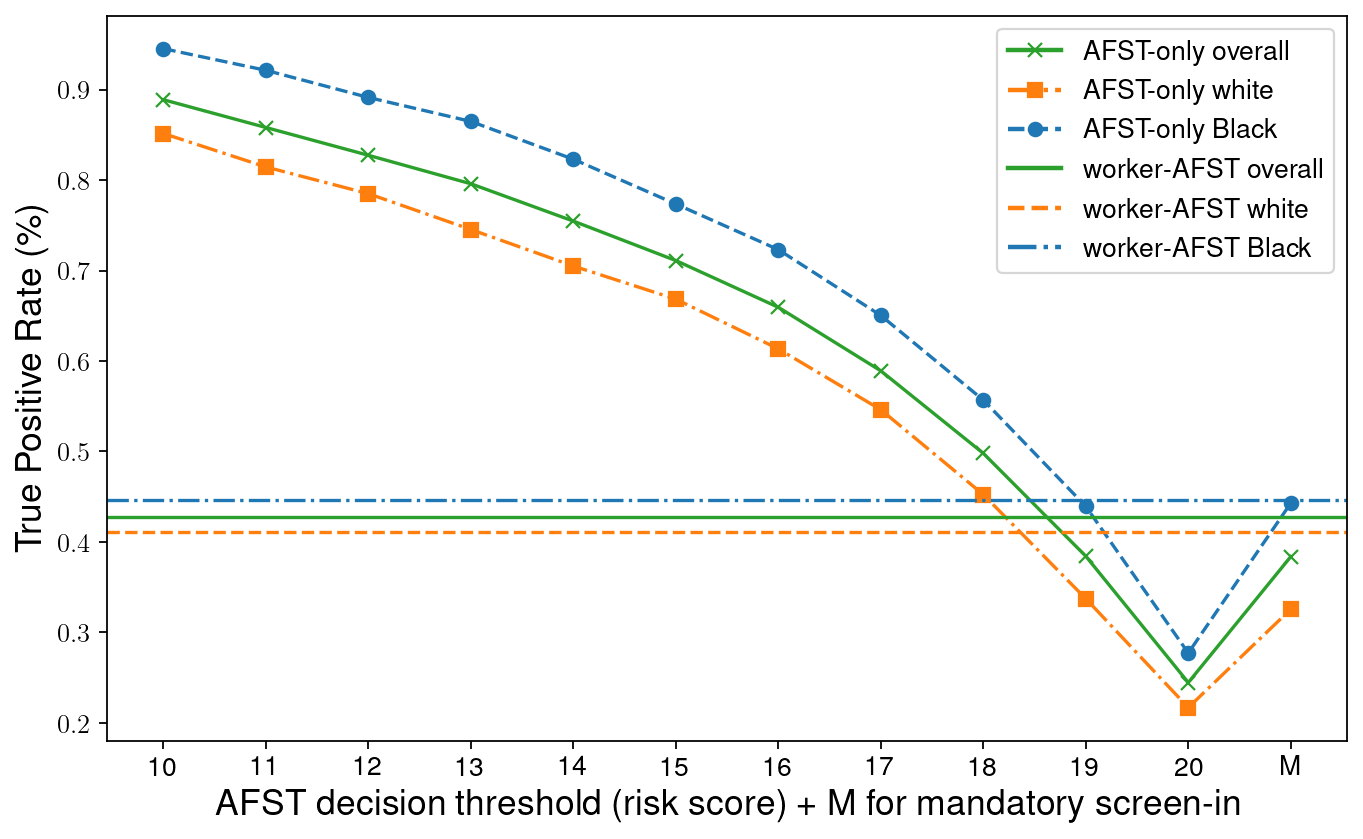

In [38]:
## calculate tpr for referrals from August 2016 to May 2018

# set up predictions & outcomes
human_AI_decision = post_df['CALL_SCRN_CODE']
y_true = post_df['HighRiskOutcome']
y_pred = human_AI_decision
sens_attrs = post_df['RACE']

# calculate tpr
acc_worker = MetricFrame(metric=true_positive_rate, y_true=y_true, y_pred=y_pred, sensitive_features = sens_attrs)
humanAI_tpr = [acc_worker.overall, acc_worker.by_group['white'], acc_worker.by_group['Black']]

## AFST-only
AI_overall_tpr = {}
AI_black_tpr = {}
AI_white_tpr = {}
AI_disparity_tpr = {}
y_true = post_df['HighRiskOutcome']
sens_attrs = post_df['RACE']

for i in range(1,21):
    AI_decision = post_df['MAX_score'] >= i
    y_pred = AI_decision
    tpr_ai = MetricFrame(metric=true_positive_rate, y_true=y_true, y_pred=y_pred, sensitive_features = sens_attrs)
    
    AI_overall_tpr[i] = tpr_ai.overall
    AI_black_tpr[i] = tpr_ai.by_group['Black']
    AI_white_tpr[i] = tpr_ai.by_group['white']
    AI_disparity_tpr[i] = tpr_ai.by_group['white'] - tpr_ai.by_group['Black']
    
## calculate tpr for mandatory screen-ins
# set up predictions & outcomes
AI_decision = post_df['MANDATORY_NULL']
y_true = post_df['HighRiskOutcome']
y_pred = AI_decision
sens_attrs = post_df['RACE']

# calculate tpr
tpr_mand = MetricFrame(metric=true_positive_rate, y_true=y_true, y_pred=y_pred, sensitive_features = sens_attrs)

AI_overall_tpr['M'] = tpr_mand.overall
AI_black_tpr['M'] = tpr_mand.by_group['Black']
AI_white_tpr['M'] = tpr_mand.by_group['white']
AI_disparity_tpr['M'] = tpr_mand.by_group['white'] - tpr_ai.by_group['Black']

AI_tpr_mand = [tpr_mand.overall, tpr_mand.by_group['white'], tpr_mand.by_group['Black']]

## Plot
plt.figure(figsize=(10,6), dpi=160)

#x_ticks = range(10, 21)
# plot lines
plt.plot(list(AI_overall_tpr.keys())[9:], list(AI_overall_tpr.values())[9:], color = 'tab:green', label = "AFST-only overall", linestyle="-", marker="x")
plt.plot(list(AI_white_tpr.keys())[9:], list(AI_white_tpr.values())[9:], color = 'tab:orange', label = "AFST-only white", linestyle='-.', marker='s')
plt.plot(list(AI_black_tpr.keys())[9:], list(AI_black_tpr.values())[9:], color = 'tab:blue', label = "AFST-only Black", linestyle="--", marker='o')

plt.axhline(humanAI_tpr[0], color = 'tab:green', label = "worker-AFST overall", linestyle="-")
plt.axhline(humanAI_tpr[1], color = 'tab:orange', label = "worker-AFST white", linestyle="--")
plt.axhline(humanAI_tpr[2], color = 'tab:blue', label = "worker-AFST Black", linestyle="-.")
# plt.plot(x_ticks, AI_white_tpr[9:], color = 'lightgrey', label = "White True Positive Rate", linestyle="-", marker='.')

# plt.plot(x_ticks, AI_disparity_tpr[9:], label = "Disparity", linestyle="-", marker='.')
plt.xlabel('AFST decision threshold (risk score) + M for mandatory screen-in', fontsize=16)
plt.ylabel('True Positive Rate (\%)', fontsize=16)
#plt.xticks(x_ticks)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

legend = plt.legend(prop={'size': 12})
for handle in legend.legendHandles:
    handle.set_linewidth(2.0)
    
plt.savefig(f'../../figures/tpr_per_threshold.png', dpi=600, bbox_inches='tight')
plt.show()

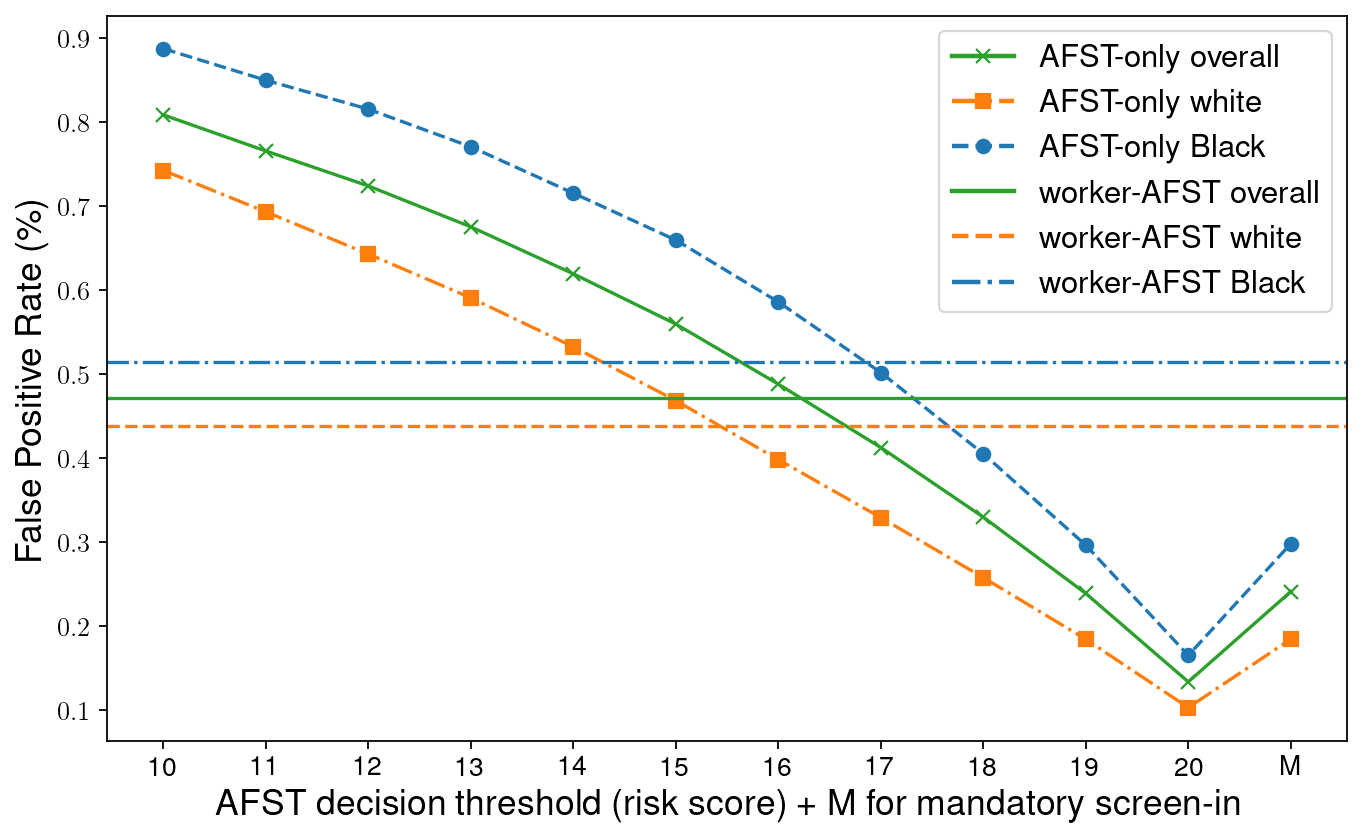

In [39]:
## calculate fpr for referrals from August 2016 to May 2018

# set up predictions & outcomes
human_AI_decision = post_df['CALL_SCRN_CODE']
y_true = post_df['HighRiskOutcome']
y_pred = human_AI_decision
sens_attrs = post_df['RACE']

# calculate fpr
acc_worker = MetricFrame(metric=false_positive_rate, y_true=y_true, y_pred=y_pred, sensitive_features = sens_attrs)
humanAI_fpr = [acc_worker.overall, acc_worker.by_group['white'], acc_worker.by_group['Black']]

## AFST-only
AI_overall_fpr = {}
AI_black_fpr = {}
AI_white_fpr = {}
AI_disparity_fpr = {}
y_true = post_df['HighRiskOutcome']
sens_attrs = post_df['RACE']

for i in range(1,21):
    AI_decision = post_df['MAX_score'] >= i
    y_pred = AI_decision
    fpr_ai = MetricFrame(metric=false_positive_rate, y_true=y_true, y_pred=y_pred, sensitive_features = sens_attrs)
    
    AI_overall_fpr[i] = fpr_ai.overall
    AI_black_fpr[i] = fpr_ai.by_group['Black']
    AI_white_fpr[i] = fpr_ai.by_group['white']
    AI_disparity_fpr[i] = fpr_ai.by_group['white'] - fpr_ai.by_group['Black']
    
## calculate fpr for mandatory screen-ins
# set up predictions & outcomes
AI_decision = post_df['MANDATORY_NULL']
y_true = post_df['HighRiskOutcome']
y_pred = AI_decision
sens_attrs = post_df['RACE']

# calculate fpr
fpr_mand = MetricFrame(metric=false_positive_rate, y_true=y_true, y_pred=y_pred, sensitive_features = sens_attrs)

AI_overall_fpr['M'] = fpr_mand.overall
AI_black_fpr['M'] = fpr_mand.by_group['Black']
AI_white_fpr['M'] = fpr_mand.by_group['white']
AI_disparity_fpr['M'] = fpr_mand.by_group['white'] - fpr_ai.by_group['Black']

AI_fpr_mand = [fpr_mand.overall, fpr_mand.by_group['white'], fpr_mand.by_group['Black']]

## Plot
plt.figure(figsize=(10,6), dpi=160)

#x_ticks = range(10, 21)
# plot lines
plt.plot(list(AI_overall_fpr.keys())[9:], list(AI_overall_fpr.values())[9:], color = 'tab:green', label = "AFST-only overall", linestyle="-", marker="x")
plt.plot(list(AI_white_fpr.keys())[9:], list(AI_white_fpr.values())[9:], color = 'tab:orange', label = "AFST-only white", linestyle='-.', marker='s')
plt.plot(list(AI_black_fpr.keys())[9:], list(AI_black_fpr.values())[9:], color = 'tab:blue', label = "AFST-only Black", linestyle="--", marker='o')

plt.axhline(humanAI_fpr[0], color = 'tab:green', label = "worker-AFST overall", linestyle="-")
plt.axhline(humanAI_fpr[1], color = 'tab:orange', label = "worker-AFST white", linestyle="--")
plt.axhline(humanAI_fpr[2], color = 'tab:blue', label = "worker-AFST Black", linestyle="-.")
# plt.plot(x_ticks, AI_white_fpr[9:], color = 'lightgrey', label = "White False Positive Rate", linestyle="-", marker='.')

# plt.plot(x_ticks, AI_disparity_fpr[9:], label = "Disparity", linestyle="-", marker='.')
plt.xlabel('AFST decision threshold (risk score) + M for mandatory screen-in', fontsize=16)
plt.ylabel('False Positive Rate (\%)', fontsize=16)
#plt.xticks(x_ticks)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

legend = plt.legend(prop={'size': 14})
for handle in legend.legendHandles:
    handle.set_linewidth(2.0)
    
plt.savefig(f'../../figures/fpr_per_threshold.png', dpi=600, bbox_inches='tight')
plt.show()

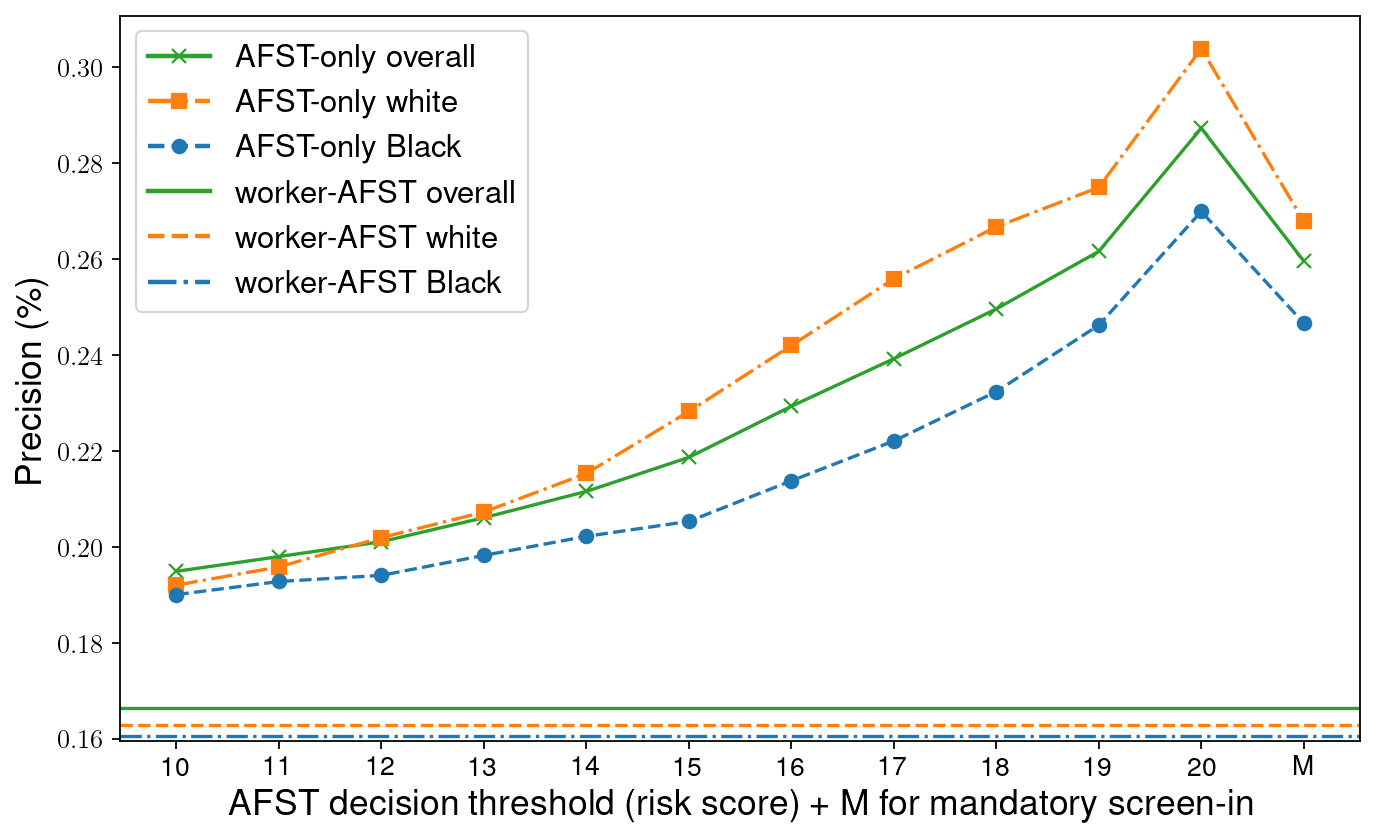

In [40]:
## calculate precision for referrals from August 2016 to May 2018

# arial font
plt.rcParams["font.family"] = 'sans-serif'

# set up predictions & outcomes
human_AI_decision = post_df['CALL_SCRN_CODE']
y_true = post_df['HighRiskOutcome']
y_pred = human_AI_decision
sens_attrs = post_df['RACE']

# calculate precision
acc_worker = MetricFrame(metric=precision_score, y_true=y_true, y_pred=y_pred, sensitive_features = sens_attrs)
humanAI_precision = [acc_worker.overall, acc_worker.by_group['white'], acc_worker.by_group['Black']]

## AFST-only
AI_overall_precision = {}
AI_black_precision = {}
AI_white_precision = {}
AI_disparity_precision = {}
y_true = post_df['HighRiskOutcome']
sens_attrs = post_df['RACE']

for i in range(1,21):
    AI_decision = post_df['MAX_score'] >= i
    y_pred = AI_decision
    precision_ai = MetricFrame(metric=precision_score, y_true=y_true, y_pred=y_pred, sensitive_features = sens_attrs)
    
    AI_overall_precision[i] = precision_ai.overall
    AI_black_precision[i] = precision_ai.by_group['Black']
    AI_white_precision[i] = precision_ai.by_group['white']
    AI_disparity_precision[i] = precision_ai.by_group['white'] - precision_ai.by_group['Black']
    
## calculate precision for mandatory screen-ins
# set up predictions & outcomes
AI_decision = post_df['MANDATORY_NULL']
y_true = post_df['HighRiskOutcome']
y_pred = AI_decision
sens_attrs = post_df['RACE']

# calculate precision
precision_mand = MetricFrame(metric=precision_score, y_true=y_true, y_pred=y_pred, sensitive_features = sens_attrs)

AI_overall_precision['M'] = precision_mand.overall
AI_black_precision['M'] = precision_mand.by_group['Black']
AI_white_precision['M'] = precision_mand.by_group['white']
AI_disparity_precision['M'] = precision_mand.by_group['white'] - precision_ai.by_group['Black']

AI_precision_mand = [precision_mand.overall, precision_mand.by_group['white'], precision_mand.by_group['Black']]

## Plot
plt.figure(figsize=(10,6), dpi=160)

#x_ticks = range(10, 21)
# plot lines
plt.plot(list(AI_overall_precision.keys())[9:], list(AI_overall_precision.values())[9:], color = 'tab:green', label = "AFST-only overall", linestyle="-", marker="x")
plt.plot(list(AI_white_precision.keys())[9:], list(AI_white_precision.values())[9:], color = 'tab:orange', label = "AFST-only white", linestyle='-.', marker='s')
plt.plot(list(AI_black_precision.keys())[9:], list(AI_black_precision.values())[9:], color = 'tab:blue', label = "AFST-only Black", linestyle="--", marker='o')

plt.axhline(humanAI_precision[0], color = 'tab:green', label = "worker-AFST overall", linestyle="-")
plt.axhline(humanAI_precision[1], color = 'tab:orange', label = "worker-AFST white", linestyle="--")
plt.axhline(humanAI_precision[2], color = 'tab:blue', label = "worker-AFST Black", linestyle="-.")
# plt.plot(x_ticks, AI_white_precision[9:], color = 'lightgrey', label = "White False Positive Rate", linestyle="-", marker='.')

# plt.plot(x_ticks, AI_disparity_precision[9:], label = "Disparity", linestyle="-", marker='.')
plt.xlabel('AFST decision threshold (risk score) + M for mandatory screen-in', fontsize=16)
plt.ylabel('Precision (\%)', fontsize=16)
#plt.xticks(x_ticks)
plt.yticks(fontsize=12,fontfamily='sans-serif')
plt.xticks(fontsize=12)

legend = plt.legend(prop={'size': 14})
for handle in legend.legendHandles:
    handle.set_linewidth(2.0)
    
plt.savefig(f'../../figures/precision_per_threshold.png', dpi=600, bbox_inches='tight')
plt.show()

## Compare disparity

In [41]:


AI_disparity_screenin_rate[1]-AI_disparity_screenin_rate[2]

0.00014787748050471006

## (Non)compliance

In [42]:
comp_gb = post_df.groupby(['MAX_level','CALL_SCRN_CODE']).size()

# % of screened-in High risk referrals
print(comp_gb['High_risk',0])
print(np.count_nonzero(post_df.MAX_level=='High_risk'))
print(round(comp_gb['High_risk',0]/np.count_nonzero(post_df.MAX_level=='High_risk')*100,1))
print()

# Medium risk referrals
print(comp_gb['Medium_risk',1])
print(np.count_nonzero(post_df.MAX_level=='Medium_risk'))
print(round((comp_gb['Medium_risk',1])/np.count_nonzero(post_df.MAX_level=='Medium_risk')*100,1))
print()


print(comp_gb['Low_risk',1])
print(np.count_nonzero(post_df.MAX_level=='Low_risk'))
print(round((comp_gb['Low_risk',1])/np.count_nonzero(post_df.MAX_level=='Low_risk')*100,1))
print()

print(comp_gb['Low_risk',1]+comp_gb['Medium_risk',1])
print(np.count_nonzero(post_df.MAX_level=='Low_risk')+np.count_nonzero(post_df.MAX_level=='Medium_risk'))
print(round((comp_gb['Low_risk',1]+comp_gb['Medium_risk',1])/(np.count_nonzero(post_df.MAX_level=='Low_risk')+np.count_nonzero(post_df.MAX_level=='Medium_risk'))*100,1))
print()

mand_gb = post_df.groupby(['MANDATORY_NULL','CALL_SCRN_CODE']).size()
print(mand_gb[1,0])
print(np.count_nonzero(post_df.MANDATORY_NULL==1))
print(round(mand_gb[1,0]/np.count_nonzero(post_df.MANDATORY_NULL==1)*100,1))
print()


print((comp_gb['High_risk',0]+comp_gb['Medium_risk',0]+comp_gb['Low_risk',0]))
print(len(post_df))
print()

print(round((comp_gb['High_risk',0]+comp_gb['Medium_risk',1]+comp_gb['Low_risk',1])/len(post_df)*100,1))
print(round((comp_gb['High_risk',0]+comp_gb['Low_risk',1])/(len(post_df)-np.count_nonzero(post_df.MAX_level == 'Medium_risk'))*100,1))



8675
20645
42.0

2980
8309
35.9

1357
6233
21.8

4337
14542
29.8

2585
9385
27.5

18880
35187

37.0
37.3


In [43]:
comp_gb = post_df.groupby(['MAX_level','CALL_SCRN_CODE','RACE']).size()

comp_screenin_black = comp_gb['High_risk',1,'Black']
noncomp_screenin_black = comp_gb['High_risk',0,'Black']
comp_screenout_black = sum(comp_gb[:,1,'Black']) - comp_gb['High_risk',1,'Black']
noncomp_screenout_black = sum(comp_gb[:,0,'Black']) - comp_gb['High_risk',0,'Black']
total_rfrl_black = sum(comp_gb[:,:,'Black'])

comp_screenin_white = comp_gb['High_risk',1,'white']
noncomp_screenin_white = comp_gb['High_risk',0,'white']
comp_screenout_white = sum(comp_gb[:,1,'white']) - comp_gb['High_risk',1,'white']
noncomp_screenout_white = sum(comp_gb[:,0,'white']) - comp_gb['High_risk',0,'white']
total_rfrl_white = sum(comp_gb[:,:,'white'])

print(comp_screenin_black/total_rfrl_black)
print(noncomp_screenin_black/total_rfrl_black)
print(comp_screenout_black/total_rfrl_black)
print(noncomp_screenout_black/total_rfrl_black)

print(comp_screenin_white/total_rfrl_white)
print(noncomp_screenin_white/total_rfrl_white)
print(comp_screenout_white/total_rfrl_white)
print(noncomp_screenout_white/total_rfrl_white)


0.39908970444201186
0.28086650918937606
0.1029555798813159
0.21708820648729618
0.28781270044900575
0.21475304682488774
0.145349583066068
0.3520846696600385


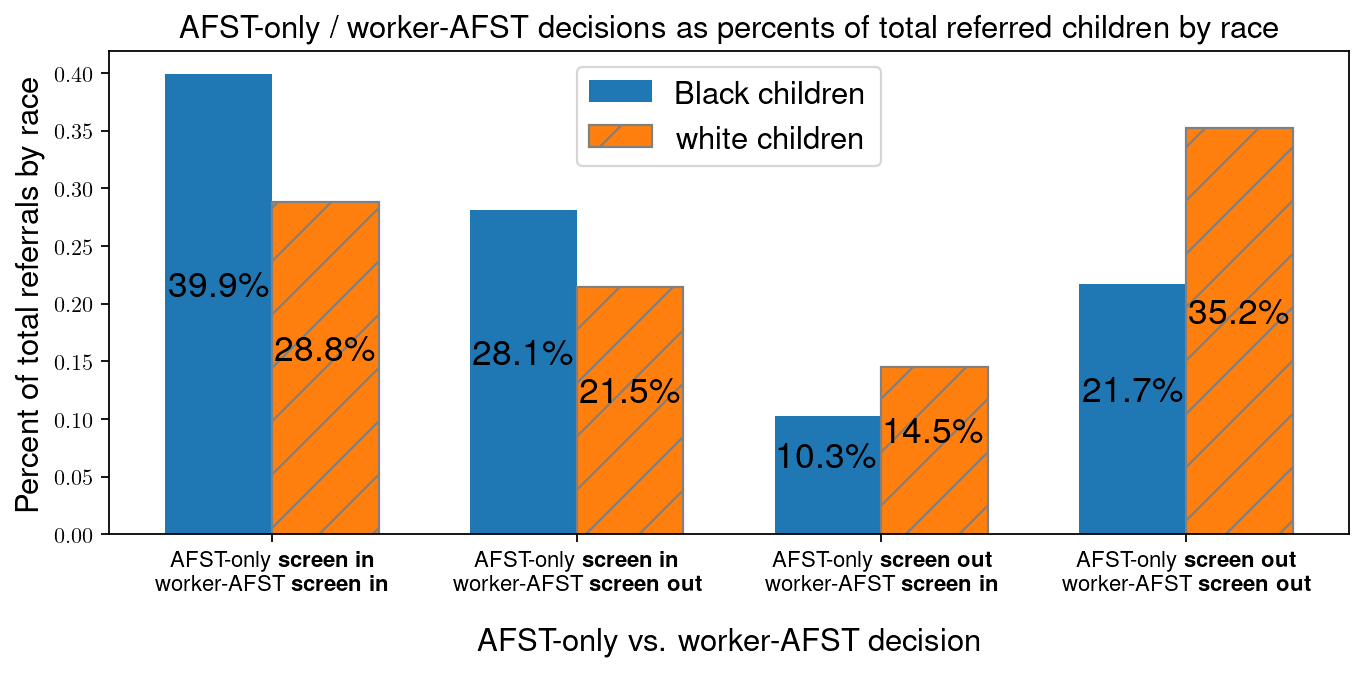

In [44]:
temp1 = [comp_screenin_black/total_rfrl_black,
         noncomp_screenin_black/total_rfrl_black,
         comp_screenout_black/total_rfrl_black,
         noncomp_screenout_black/total_rfrl_black]

temp2 = [comp_screenin_white/total_rfrl_white,
         noncomp_screenin_white/total_rfrl_white,
         comp_screenout_white/total_rfrl_white,
         noncomp_screenout_white/total_rfrl_white]

labels = ["AFST-only " + r"\textbf{" + 'screen in' + "}" + "\n worker-AFST " + r"\textbf{" + 'screen in' + "}",
          "AFST-only " + r"\textbf{" + 'screen in' + "}" + "\n worker-AFST " + r"\textbf{" + 'screen out' + "}",
          "AFST-only " + r"\textbf{" + 'screen out' + "}" + "\n worker-AFST " + r"\textbf{" + 'screen in' + "}",
          "AFST-only " + r"\textbf{" + 'screen out' + "}" + "\n worker-AFST " + r"\textbf{" + 'screen out' + "}"]

N = len(labels)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(10, 4), dpi=160)

rects1 = ax.bar(ind, temp1, width, color='tab:blue')
rects2 = ax.bar(ind + width, temp2, width, color='tab:orange', edgecolor='grey', hatch="/")

# add some text for labels, title and axes ticks
ax.set_ylabel('Percent of total referrals by race',fontsize=14)
ax.set_xlabel('AFST-only vs. worker-AFST decision',fontsize=14,labelpad=15)
ax.set_title('AFST-only / worker-AFST decisions as percents of total referred children by race',fontsize=14)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels)

ax.legend((rects1[0], rects2[0]), ('Black children', 'white children'), fontsize=14)


def rect_label(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .5*height,
                str(round(height*100,1))+'\%',
                ha='center', va='bottom',fontsize=16)

rect_label(rects1)
rect_label(rects2)

plt.savefig('../../figures/human-ai_compliance_breakdown.png', dpi=600, bbox_inches='tight')
plt.show()

In [45]:
# total % of noncompliance between workers and AFST
np.mean(post_df['CALL_SCRN_CODE'] == (post_df['MAX_score'] >= 15))


0.6302043368289425

# Appendix

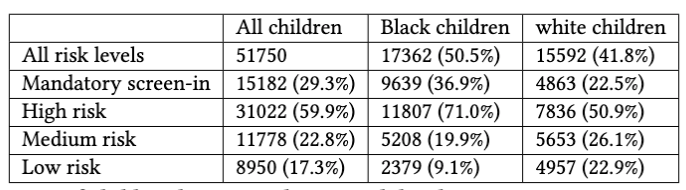

In [46]:
len(post_df)
post_df.RACE == 'Black'

0        False
1        False
2         True
3         True
4        False
         ...  
36021     True
36022     True
36023     True
36024    False
36025    False
Name: RACE, Length: 35187, dtype: bool

In [47]:
all_all = len(post_df)
all_mand = len(post_df[post_df.MANDATORY_NULL==1])
all_high = len(post_df[post_df.MAX_level=='High_risk'])
all_med = len(post_df[post_df.MAX_level=='Medium_risk'])
all_low = len(post_df[post_df.MAX_level=='Low_risk'])

Black_all = len(post_df[post_df.RACE=='Black'])
Black_mand = len(post_df[(post_df.MANDATORY_NULL==1)&(post_df.RACE=='Black')])
Black_high = len(post_df[(post_df.MAX_level=='High_risk')&(post_df.RACE=='Black')])
Black_med = len(post_df[(post_df.MAX_level=='Medium_risk')&(post_df.RACE=='Black')])
Black_low = len(post_df[(post_df.MAX_level=='Low_risk')&(post_df.RACE=='Black')])

white_all = len(post_df[post_df.RACE=='white'])
white_mand = len(post_df[(post_df.MANDATORY_NULL==1)&(post_df.RACE=='white')])
white_high = len(post_df[(post_df.MAX_level=='High_risk')&(post_df.RACE=='white')])
white_med = len(post_df[(post_df.MAX_level=='Medium_risk')&(post_df.RACE=='white')])
white_low = len(post_df[(post_df.MAX_level=='Low_risk')&(post_df.RACE=='white')])

In [48]:
def pct(num,denom):
    return round(num/denom*100,1)

In [49]:
# race_risklevel
print(f"  &  All referral-children &  Black referral-children & white referral-children \\\\ \hline\nAll risk levels  & {all_all}   & {Black_all} ({pct(Black_all,all_all)}\%) & {white_all} ({pct(white_all,all_all)}\%) \\\\ \hline\nMandatory screen-in & {all_mand} ({pct(all_mand,all_all)}\%) & {Black_mand} ({pct(Black_mand,Black_all)}\%) & {white_mand} ({pct(white_mand,white_all)}\%) \\\\ \hline\nHigh risk & {all_high} ({pct(all_high,all_all)}\%) & {Black_high} ({pct(Black_high,Black_all)}\%) & {white_high} ({pct(white_high,white_all)}\%) \\\\ \hline\nMedium risk & {all_med} ({pct(all_med,all_all)}\%) & {Black_med} ({pct(Black_med,Black_all)}\%) & {white_med} ({pct(white_med,white_all)}\%) \\\\ \hline\nLow risk & {all_low} ({pct(all_low,all_all)}\%) & {Black_low} ({pct(Black_low,Black_all)}\%) & {white_low} ({pct(white_low,white_all)}\%) \\\\ \hline\n")

  &  All referral-children &  Black referral-children & white referral-children \\ \hline
All risk levels  & 35187   & 17357 (49.3\%) & 15590 (44.3\%) \\ \hline
Mandatory screen-in & 9385 (26.7\%) & 5624 (32.4\%) & 3252 (20.9\%) \\ \hline
High risk & 20645 (58.7\%) & 11802 (68.0\%) & 7835 (50.3\%) \\ \hline
Medium risk & 8309 (23.6\%) & 3779 (21.8\%) & 4028 (25.8\%) \\ \hline
Low risk & 6233 (17.7\%) & 1776 (10.2\%) & 3727 (23.9\%) \\ \hline



## Compare accuracy for each score / mandatory screen-ins

In [50]:
post_df_mand = post_df[post_df['MANDATORY_NULL']==1]
post_df_mand_screenin = post_df_mand[post_df_mand['CALL_SCRN_CODE']==1]
np.count_nonzero(post_df_mand_screenin['HighRiskOutcome'])/len(post_df_mand_screenin)

0.23676470588235293

In [51]:
np.count_nonzero(post_df_mand['HighRiskOutcome'])/len(post_df_mand)

0.2595631326584976

In [52]:
# group by mandatory screen-in and max AFST scores
test = post_df.groupby(['MANDATORY_NULL','CALL_SCRN_CODE','HighRiskOutcome']).size()
test1 = post_df.groupby(['MAX_score','CALL_SCRN_CODE','HighRiskOutcome']).size()

workerAFST_hro_binned = {}
workerAFST_accuracy_binned = {}
AFSTonly_accuracy_binned = {}
AFSTonly_hro_binned = {}

workerAFST_hro_binned_denom = {}
workerAFST_accuracy_binned_denom = {}
AFSTonly_accuracy_binned_denom = {}
AFSTonly_hro_binned_denom = {}

# measure scores 1-9 by screen out accuracy
for score in range(1,10):
    post_df_score = post_df[post_df['MAX_score']==score]
    y_pred = post_df_score['CALL_SCRN_CODE']
    y_true = 1 - post_df_score['HighRiskOutcome']
    sens_attrs = post_df_score['RACE']
    
    workerAFST_accuracy_binned[score] = round(MetricFrame(metric=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=sens_attrs).overall*100,1)
    workerAFST_accuracy_binned_denom[score] = len(sens_attrs)
    
    AFSTonly_accuracy_binned[score] = round(sum(test1[score][:,0])/sum(test1[score])*100,1)
    AFSTonly_accuracy_binned_denom[score] = sum(test1[score])
    
    workerAFST_hro_binned[score] = round(test1[score][0,1]/sum(test1[score][1])*100,1)
    workerAFST_hro_binned_denom[score] = sum(test1[score][0])
    
    
    AFSTonly_hro_binned[score] = round(sum(test1[score][:,1])/sum(test1[score])*100,1)
    AFSTonly_hro_binned_denom[score] = sum(test1[score])
    
# measure scores 15-20 by screen in accuracy
for score in range(15,21):
    post_df_score = post_df[post_df['MAX_score']==score]
    y_pred = 1 - post_df_score['CALL_SCRN_CODE']
    y_true = post_df_score['HighRiskOutcome']
    sens_attrs = post_df_score['RACE']
    
    workerAFST_accuracy_binned[score] = round(MetricFrame(metric=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=sens_attrs).overall*100,1)
    workerAFST_accuracy_binned_denom[score] = len(sens_attrs)
    
    AFSTonly_accuracy_binned[score] = round(sum(test1[score][:,1])/sum(test1[score])*100,1)
    AFSTonly_accuracy_binned_denom[score] = sum(test1[score])
    
    workerAFST_hro_binned[score] = round(test1[score][0,1]/sum(test1[score][0])*100,1)
    workerAFST_hro_binned_denom[score] = sum(test1[score][0])
    
    AFSTonly_hro_binned[score] = AFSTonly_accuracy_binned[score]
    AFSTonly_hro_binned_denom[score] = AFSTonly_accuracy_binned_denom[score]
    
# add mandatory screen-in cases
post_df_mand = post_df[post_df['MANDATORY_NULL']==1]
y_pred = 1 - post_df_mand['CALL_SCRN_CODE']
y_true = post_df_mand['HighRiskOutcome']
sens_attrs = post_df_mand['RACE']

workerAFST_accuracy_binned['M'] = round(MetricFrame(metric=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=sens_attrs).overall*100,1)
workerAFST_accuracy_binned_denom['M'] = len(sens_attrs)

AFSTonly_accuracy_binned['M'] = round(sum(test[1][:,1])/sum(test[1])*100,1)
AFSTonly_accuracy_binned_denom['M'] = sum(test[1])

workerAFST_hro_binned['M'] = round(test[1][0][1]/sum(test[1][0])*100,1)
workerAFST_hro_binned_denom['M'] = sum(test[1][0])

AFSTonly_hro_binned['M'] = AFSTonly_accuracy_binned['M']
AFSTonly_hro_binned_denom['M'] = AFSTonly_accuracy_binned_denom['M']


KeyError: 1

In [ ]:
workerAFST_accuracy_binned.values()

In [ ]:
AFSTonly_accuracy_binned.values()

In [ ]:
workerAFST_accuracy_binned_denom.values()

In [ ]:
AFSTonly_hro_binned.values()

In [ ]:
AFSTonly_hro_binned_denom.values()

In [ ]:
workerAFST_hro_binned.values()

In [ ]:
workerAFST_hro_binned_denom.values()

### By race & risk level

In [ ]:
print(len(post_df))
print(np.count_nonzero(post_df['MANDATORY_NULL']))
print(np.count_nonzero(post_df['MAX_score']>=15))
print(np.count_nonzero(post_df['MAX_level']=='Medium_risk'))
print(np.count_nonzero(post_df['MAX_level']=='Low_risk'))

print(round(np.count_nonzero(post_df['MANDATORY_NULL'])/len(post_df)*100,1))
print(round(np.count_nonzero(post_df['MAX_score']>=15)/len(post_df)*100,1))
print(round(np.count_nonzero(post_df['MAX_level']=='Medium_risk')/len(post_df)*100,1))
print(round(np.count_nonzero(post_df['MAX_level']=='Low_risk')/len(post_df)*100,1))

print()
print(np.count_nonzero(post_df['RACE']=='Black'))
print(np.count_nonzero(post_df['RACE']=='white'))

print(round(np.count_nonzero(post_df['RACE']=='Black')/len(post_df)*100,1))
print(round(np.count_nonzero(post_df['RACE']=='white')/len(post_df)*100,1))

print()
print(np.count_nonzero(post_df['MANDATORY_NULL'] & (post_df['RACE']=='Black')))
print(np.count_nonzero((post_df['MAX_score']>=15) & (post_df['RACE']=='Black')))
print(np.count_nonzero((post_df['MAX_level']=='Medium_risk') & (post_df['RACE']=='Black')))
print(np.count_nonzero((post_df['MAX_level']=='Low_risk') & (post_df['RACE']=='Black')))

print(round(np.count_nonzero(post_df['MANDATORY_NULL'] & (post_df['RACE']=='Black'))/np.count_nonzero(post_df['RACE']=='Black')*100,1))
print(round(np.count_nonzero((post_df['MAX_score']>=15) & (post_df['RACE']=='Black'))/np.count_nonzero(post_df['RACE']=='Black')*100,1))
print(round(np.count_nonzero((post_df['MAX_level']=='Medium_risk') & (post_df['RACE']=='Black'))/np.count_nonzero(post_df['RACE']=='Black')*100,1))
print(round(np.count_nonzero((post_df['MAX_level']=='Low_risk') & (post_df['RACE']=='Black'))/np.count_nonzero(post_df['RACE']=='Black')*100,1))

print()
print(np.count_nonzero(post_df['MANDATORY_NULL'] & (post_df['RACE']=='white')))
print(np.count_nonzero((post_df['MAX_score']>=15) & (post_df['RACE']=='white')))
print(np.count_nonzero((post_df['MAX_level']=='Medium_risk') & (post_df['RACE']=='white')))
print(np.count_nonzero((post_df['MAX_level']=='Low_risk') & (post_df['RACE']=='white')))

print(round(np.count_nonzero(post_df['MANDATORY_NULL'] & (post_df['RACE']=='white'))/np.count_nonzero(post_df['RACE']=='white')*100,1))
print(round(np.count_nonzero((post_df['MAX_score']>=15) & (post_df['RACE']=='white'))/np.count_nonzero(post_df['RACE']=='white')*100,1))
print(round(np.count_nonzero((post_df['MAX_level']=='Medium_risk') & (post_df['RACE']=='white'))/np.count_nonzero(post_df['RACE']=='white')*100,1))
print(round(np.count_nonzero((post_df['MAX_level']=='Low_risk') & (post_df['RACE']=='white'))/np.count_nonzero(post_df['RACE']=='white')*100,1))


In [ ]:
print(post_df.loc[post_df['MANDATORY_NULL']==1]['REFER_ID'].nunique()/post_df['REFER_ID'].nunique())
print(len(post_df.loc[post_df['MANDATORY_NULL']==1])/len(post_df))
print(len(post_df.loc[(post_df['MANDATORY_NULL']==1)&(post_df['CALL_SCRN_CODE']==1)])/len(post_df.loc[post_df['MANDATORY_NULL']==1]))
          